In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch
import torch.autograd as autograd
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
#from torchviz import make_dot
from transformers import AutoTokenizer, GPT2LMHeadModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.autograd as autograd
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
#from torchviz import make_dot
from transformers import AutoTokenizer, GPT2LMHeadModel

from undecorated import undecorated
from types import MethodType
import time
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

import pickle
import io
import os

# own functions
from training import ReverseEngineer

/Users/hoener/miniforge3/envs/mphil/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pickle
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

def load_embeddings(sPathEmbeddings, sNameEmbeddingA, sNameEmbeddingB):
    
    # Load pickle file
    with open(sPathEmbeddings + "/" + sNameEmbeddingA, 'rb') as f:
        lEmbeddingsA = CPU_Unpickler(f).load()
    
    with open(sPathEmbeddings + "/" + sNameEmbeddingB, 'rb') as f:
        lEmbeddingsB = CPU_Unpickler(f).load()
        
    tEmbeddingA = torch.concatenate(lEmbeddingsA, dim=1)
    tEmbeddingB = torch.concatenate(lEmbeddingsB, dim=1)
    
    tEmbeddingA = tEmbeddingA.squeeze()
    tEmbeddingB = tEmbeddingB.squeeze()
        
    return tEmbeddingA, tEmbeddingB

sPathEmbeddings = "../../data/processed/summary_embeddings/"
sNameEmbeddingA = "tangible_hair_prec.pkl"
sNameEmbeddingB = "intangible_hair_prec.pkl"

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
torch.set_default_device(device)
#torch.set_default_device("cpu")
print(f"Using {device} device")
print(torch.tensor([1, 2, 3]).device)

Using mps device
mps:0


In [5]:
# Hair product
lClaimsHair = [
    "Experience mirror-like shine with every wash.",
    "Get dazzling, glossy hair in just one use.",
    "Transform dull strands into radiant locks.",
    "Achieve salon-quality shine at home.",
    "Enhance natural brilliance with our advanced formula.",
    "Unlock the confidence of luminous hair that turns heads.",
    "Experience the joy of hair that gleams with vitality.",
    "Embrace the radiance of hair that reflects your inner beauty.",
    "Elevate your everyday with hair that shines with sophistication.",
    "Feel the allure of irresistibly shiny hair that captivates."
]

tEmbeddingA, tEmbeddingB = load_embeddings(sPathEmbeddings, sNameEmbeddingA, sNameEmbeddingB)
tEmbeddings = torch.cat([tEmbeddingA, tEmbeddingB], dim=0)
tEmbeddings = torch.load("embedding_pred.pt")

In [6]:
# INIT
i_seed_value = 42
s_model = "gpt2"
s_target_string = "The"

torch.manual_seed(i_seed_value)
model = GPT2LMHeadModel.from_pretrained(s_model)
tokenizer = AutoTokenizer.from_pretrained(s_model)
tokenizer.pad_token_id = tokenizer.eos_token_id

# BUG: Issue that greedy search does not find max likelihood sequence? Does this matter?
i_num_beams = 1 # greedy search for i_num_beams = 1
i_no_repeat_ngram_size = 1 # TODO: This creates inplace gradient error
i_num_return = 1
i_max_new_tokens = tokenizer.encode(s_target_string, return_tensors="pt").shape[1]

# TODO: Link to this https://github.com/huggingface/transformers/issues/15552 (last comment)
generate_with_grad = model.generate.__closure__[1].cell_contents
model.generate_with_grad = MethodType(generate_with_grad, model)
input_embedding = autograd.Variable(torch.mean(model.get_input_embeddings()(tokenizer.encode(s_target_string, return_tensors="pt")), 1, keepdim=True), requires_grad=True)
gd = torch.optim.RMSprop([input_embedding],
                            lr=1, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False, foreach=None, maximize=False, differentiable=False)

print(f"Dimensions of input embedding: {input_embedding.shape}")
target_sequence = tokenizer.encode(s_target_string, return_tensors="pt")
print("TARGET IN TOKENS")

fn_generate = lambda x: model.generate_with_grad(
        inputs_embeds=x,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id,
        max_new_tokens=i_max_new_tokens,
        num_beams=i_num_beams,
        num_return_sequences=i_num_return,
        return_dict_in_generate=True,
        output_scores=True)


Dimensions of input embedding: torch.Size([1, 1, 768])
TARGET IN TOKENS


In [7]:
input_embedding.shape

torch.Size([1, 1, 768])

In [8]:
# MAGICKS
iClaims = 10
iRank = 3
iEmbeddingDim = 768
target_sequence = tokenizer.encode(s_target_string, return_tensors="pt")
RE = ReverseEngineer(target_sequence = target_sequence)

In [8]:
#RE.training_joint(input_embedding, tokenizer, gd, fn_generate_full)

In [9]:
import torch
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self, iClaims, iRank, iEmbeddingDim):
        super(NeuralNetwork, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(iClaims, iRank)  # First layer
        self.fc2 = nn.Linear(iRank, iEmbeddingDim)  # Second layer
        self.fc3 = nn.Linear(iEmbeddingDim, iEmbeddingDim)  # Third layer
        
        # Define activation function
        self.activation = lambda x: x  # You can change this to other activation functions if needed
    
    def forward(self, x):
        # Forward pass through the network
        x = self.activation(self.fc1(x))  # Pass through first layer with activation
        x = self.activation(self.fc2(x))  # Pass through second layer with activation
        x = self.fc3(x)  # Pass through third layer without activation (if needed)
        return x

class NeuralNetworkSmall(nn.Module):
    def __init__(self, iClaims, iEmbeddingDim):
        super(NeuralNetworkSmall, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(iClaims, iEmbeddingDim)
        self.fc2 = nn.Linear(iEmbeddingDim, iEmbeddingDim)
        
        # Define activation function
        self.activation = lambda x: x  # You can change this to other activation functions if needed
    
    def forward(self, x):
        # Forward pass through the network
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x


In [10]:
# Example usage:
# Initialize the neural network with specified dimensions
iClaims = 10  # Example number of nodes in the first layer
iRank = 20  # Example number of nodes in the second layer
iEmbeddingDim = 768  # Example number of nodes in the third layer
NN = NeuralNetwork(iClaims, iRank, iEmbeddingDim)
NNSmall = NeuralNetworkSmall(iClaims, iEmbeddingDim)

# Example input data
vInput = torch.zeros(iClaims)
vInput[0] = 1  
input_data = vInput

# Forward pass through the network
output = NN(input_data)
output_small = NNSmall(input_data)

print(output)
output.shape
output_small.shape

tensor([-3.4157e-02, -1.6007e-01, -1.2431e-01,  6.3415e-02,  6.3964e-02,
         9.4652e-02,  1.7745e-01,  9.5643e-02,  1.7763e-02, -2.0030e-01,
        -6.5360e-02,  1.9002e-01,  1.2265e-01, -1.4012e-02,  5.9754e-02,
         7.8791e-02, -1.3469e-01,  5.6972e-02, -7.9445e-02, -1.5927e-01,
         4.0516e-02,  1.7907e-02, -1.0745e-02, -1.4891e-01,  4.1154e-02,
        -1.3215e-01,  1.0389e-02,  1.0350e-01, -1.1523e-01,  8.4456e-02,
         9.0553e-02, -5.9833e-02,  3.6320e-02,  1.0958e-02, -3.3427e-02,
         9.1050e-02,  7.9914e-02, -6.8134e-02,  3.1428e-01, -6.5907e-02,
         9.6125e-02,  6.5612e-02,  4.5382e-02, -1.1537e-01,  1.4414e-01,
         9.1217e-02, -1.8767e-02, -3.2847e-02, -7.8651e-02, -9.8111e-03,
        -2.0190e-01,  5.0902e-02, -6.5967e-02, -1.0815e-01, -7.5000e-02,
         8.5129e-03, -1.9480e-01, -9.9277e-02, -1.5526e-01, -7.3397e-02,
         4.1757e-02, -9.1107e-03,  1.0868e-02,  5.6699e-03, -3.3464e-02,
         1.8001e-01, -3.1639e-02,  4.3359e-02,  1.6

torch.Size([768])

In [11]:
tEmbeddingA[0].shape

torch.Size([768])

In [12]:
# Level 1, have a iClaims length OHE vector for the claims: This is the input to the model

# Level 2, have a iRank node layer with linear activation function

# Level 3, have the "summary embedding" of iEmbeddingDim

In [3]:
def llikelihood(output: tuple, target_sequence) -> float:
    """Calculate the log-likelihood of the target tokens in the output sequence.
    NOTE: This only works for greedy search, not beam search (i.e. set num_beams=1).
    NOTE: We use a minimizer

    Args:
        output (tuple): Output from a HF LLM text generation model. Only pass one sequence.
        target_sequence (torch.Tensor): The target tokens (the sequence) to calculate the log-likelihood of.

    Returns:
        float: log-llikelihood for the sequence
    """

    # get scores and the sequences
    scores = torch.stack(output.scores).reshape(len(output.scores), -1).transpose(0, 1)

    # get the scores into a matrix, use log_softmax
    m_prob = torch.nn.functional.log_softmax(scores, dim=0)
    m_prob_sub = m_prob[target_sequence.squeeze()]

    # get the diagonal of the matrix
    v_trans_prob = torch.diag(m_prob_sub)
    d_llikelihood = torch.sum(v_trans_prob) * (-1)

    return d_llikelihood

In [18]:
s_target_string = "can"
target_sequence = tokenizer.encode(s_target_string, return_tensors="pt")
summary_embedding = autograd.Variable(torch.mean(model.get_input_embeddings()(target_sequence), 1, keepdim=True), requires_grad=True)
argument = autograd.Variable(torch.rand(iClaims), requires_grad=True)
gd = torch.optim.RMSprop([summary_embedding],
                            lr=1e-1, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False, foreach=None, maximize=False, differentiable=False)
gd = torch.optim.RMSprop([argument],
                            lr=1e-1, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False, foreach=None, maximize=False, differentiable=False)


In [ ]:
fn_generate(summary_embedding)

GreedySearchDecoderOnlyOutput(sequences=tensor([[50256,    13]]), scores=(tensor([[-32.8368, -32.1103, -35.6766,  ..., -41.2087, -40.9105, -33.0429]],
       grad_fn=<SliceBackward0>),), attentions=None, hidden_states=None)

In [ ]:
# # Defining Autoencoder model
class Autoencoder(nn.Module):
   def __init__(self, input_size, encoding_dim, output_size):
       super(Autoencoder, self).__init__()
       self.encoder = nn.Sequential(
           nn.Linear(input_size, encoding_dim)
       )
       self.decoder = nn.Sequential(
           nn.Linear(encoding_dim, output_size)
       )

   def forward(self, x):
       x = self.encoder(x)
       x = self.decoder(x)
       return x


# Setting random seed for reproducibility
torch.manual_seed(4523522)

input_size = tOHETarget.shape[1]  # Number of input features
encoding_dim = 3  # Desired number of output dimensions
output_size = tEmbeddings.shape[1]  # Number of output features
ae = Autoencoder(input_size, encoding_dim, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=0.003)

# Training the autoencoder
num_epochs = 1000
for epoch in range(num_epochs):
   # Forward pass
   outputs = ae(tOHETarget)
   loss = criterion(outputs, tEmbeddings)

   # Backward pass and optimization
   optimizer.zero_grad()
   loss.backward()
   optimizer.step()

   # Loss for each epoch
   print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Encoding the data using the trained autoencoder
encoded_data = ae.encoder(tOHETarget).detach().numpy()

Epoch [1/1000], Loss: 9.7213
Epoch [2/1000], Loss: 9.7099
Epoch [3/1000], Loss: 9.6985
Epoch [4/1000], Loss: 9.6870
Epoch [5/1000], Loss: 9.6755
Epoch [6/1000], Loss: 9.6638
Epoch [7/1000], Loss: 9.6521
Epoch [8/1000], Loss: 9.6403
Epoch [9/1000], Loss: 9.6284
Epoch [10/1000], Loss: 9.6163
Epoch [11/1000], Loss: 9.6042
Epoch [12/1000], Loss: 9.5918
Epoch [13/1000], Loss: 9.5793
Epoch [14/1000], Loss: 9.5667
Epoch [15/1000], Loss: 9.5539
Epoch [16/1000], Loss: 9.5408
Epoch [17/1000], Loss: 9.5276
Epoch [18/1000], Loss: 9.5142
Epoch [19/1000], Loss: 9.5005
Epoch [20/1000], Loss: 9.4866
Epoch [21/1000], Loss: 9.4725
Epoch [22/1000], Loss: 9.4582
Epoch [23/1000], Loss: 9.4436
Epoch [24/1000], Loss: 9.4287
Epoch [25/1000], Loss: 9.4136
Epoch [26/1000], Loss: 9.3983
Epoch [27/1000], Loss: 9.3826
Epoch [28/1000], Loss: 9.3667
Epoch [29/1000], Loss: 9.3506
Epoch [30/1000], Loss: 9.3341
Epoch [31/1000], Loss: 9.3174
Epoch [32/1000], Loss: 9.3004
Epoch [33/1000], Loss: 9.2831
Epoch [34/1000], Lo

Epoch [317/1000], Loss: 5.9260
Epoch [318/1000], Loss: 5.9197
Epoch [319/1000], Loss: 5.9135
Epoch [320/1000], Loss: 5.9072
Epoch [321/1000], Loss: 5.9010
Epoch [322/1000], Loss: 5.8948
Epoch [323/1000], Loss: 5.8887
Epoch [324/1000], Loss: 5.8825
Epoch [325/1000], Loss: 5.8764
Epoch [326/1000], Loss: 5.8703
Epoch [327/1000], Loss: 5.8642
Epoch [328/1000], Loss: 5.8581
Epoch [329/1000], Loss: 5.8521
Epoch [330/1000], Loss: 5.8460
Epoch [331/1000], Loss: 5.8400
Epoch [332/1000], Loss: 5.8340
Epoch [333/1000], Loss: 5.8281
Epoch [334/1000], Loss: 5.8221
Epoch [335/1000], Loss: 5.8162
Epoch [336/1000], Loss: 5.8103
Epoch [337/1000], Loss: 5.8044
Epoch [338/1000], Loss: 5.7985
Epoch [339/1000], Loss: 5.7927
Epoch [340/1000], Loss: 5.7868
Epoch [341/1000], Loss: 5.7810
Epoch [342/1000], Loss: 5.7752
Epoch [343/1000], Loss: 5.7695
Epoch [344/1000], Loss: 5.7637
Epoch [345/1000], Loss: 5.7580
Epoch [346/1000], Loss: 5.7522
Epoch [347/1000], Loss: 5.7465
Epoch [348/1000], Loss: 5.7408
Epoch [3

In [ ]:
tEmbedAE = ae(tOHETarget[0, :]).reshape(1, -1)

In [ ]:
tEmbedAE.shape

torch.Size([1, 768])

In [ ]:
fn_generate(ae(tOHETarget[0, :]).reshape(1, 1, -1))

GreedySearchDecoderOnlyOutput(sequences=tensor([[50256, 35476]]), scores=(tensor([[-30.1394, -24.1391, -26.0530,  ..., -41.3666, -37.0288, -28.5599]],
       grad_fn=<SliceBackward0>),), attentions=None, hidden_states=None)

In [ ]:
# vColor = torch.cat([torch.zeros(tEmbeddings.shape[0] // 2), torch.ones(tEmbeddings.shape[0] // 2)])

# # Plotting the encoded data in 3D space
# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111,  projection='3d')

# scatter = ax.scatter(encoded_data[:, 0], encoded_data[:, 1], encoded_data[:, 2], cmap='viridis', c = vColor)

# ax.set_xlabel('Encoded Dimension 1')
# ax.set_ylabel('Encoded Dimension 2')
# ax.set_title('Autoencoder Dimensionality Reduction')

# plt.tight_layout()

# plt.savefig('Rain_Prediction_Autoencoder.png')

# plt.show()

In [ ]:
lClaimsHair = [
    "Experience 50% more visible shine after just one use.",
    "Formulated with light-reflecting technology for a glossy finish.",
    "Transform dull strands into radiant, luminous locks.",
    "Infused with nourishing oils that enhance natural shine.",
    "See instant brilliance with our advanced shine-boosting formula.",
    "Locks in moisture to amplify hair's natural luster.",
    "Achieve salon-quality shine without leaving home.",
    "Visible reduction in dullness, replaced with stunning shine.",
    "Say goodbye to lackluster hair, hello to mirror-like shine.",
    "Clinically proven to enhance shine by up to 70%.", # ^tangible
    "Elevate your confidence with hair that gleams under any light.",
    "Embrace the allure of luminous hair that turns heads.",
    "Unleash the power of radiant hair that speaks volumes.",
    "Transform your look with hair that exudes brilliance.",
    "Feel the difference of hair that shines with vitality and health.",
    "Rediscover the joy of hair that beams with inner vibrancy.",
    "Indulge in the luxury of hair that shimmers with elegance.",
    "Step into the spotlight with hair that radiates beauty.",
    "Experience the magic of hair that dazzles with every movement.",
    "Unlock the secret to hair that shines from within, reflecting your inner glow."
]

In [28]:
def create_input_data(iClaims):
    return torch.eye(iClaims)

fn_generate_i = lambda x, i: model.generate_with_grad(
        inputs_embeds=x,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id,
        max_new_tokens=i,
        num_beams=i_num_beams,
        num_return_sequences=i_num_return,
        return_dict_in_generate=True,
        output_scores=True)

# INIT
i_seed_value = 42
s_model = "gpt2"

torch.manual_seed(i_seed_value)
model = GPT2LMHeadModel.from_pretrained(s_model)
tokenizer = AutoTokenizer.from_pretrained(s_model)
tokenizer.pad_token_id = tokenizer.eos_token_id

# BUG: Issue that greedy search does not find max likelihood sequence? Does this matter?
i_num_beams = 1 # greedy search for i_num_beams = 1
i_no_repeat_ngram_size = 1 # TODO: This creates inplace gradient error
i_num_return = 1

# TODO: Link to this https://github.com/huggingface/transformers/issues/15552 (last comment)
generate_with_grad = model.generate.__closure__[1].cell_contents
model.generate_with_grad = MethodType(generate_with_grad, model)

lTargetStrings = [
                  "Experience 50% more visible shine after just one use.",
                  "Experience the magic of hair that dazzles with every movement.",
                  "Formulated with light-reflecting technology for a glossy finish.",
                  "Unlock the secret to hair that shines from within, reflecting your inner glow."
                  ]
# lTargetStrings = [
#                   "potato",
#                   "tomato",
#                   "bridge",
#                   "street"
#                   ]
lGenerate = []
lTargetSequence = []

for i, sTargetString in enumerate(lTargetStrings):
    lTargetSequence.append(tokenizer.encode(sTargetString, return_tensors="pt"))
    lGenerate.append(lambda x: fn_generate_i(x, lTargetSequence[i].shape[1]))
    
tOHETarget = create_input_data(len(lTargetSequence))

EPOCH 0: [nan nan nan nan], joint: nan, time: 84.7 s


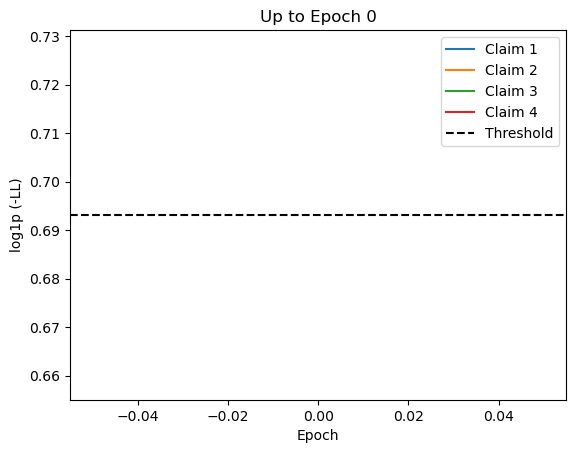

In [29]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import time

# Defining Autoencoder model
class Autoencoder(nn.Module):
   def __init__(self, input_size, encoding_dim, output_size):
       super(Autoencoder, self).__init__()
       self.encoder = nn.Sequential(
           nn.Linear(input_size, encoding_dim)
       )
       self.decoder = nn.Sequential(
           nn.Linear(encoding_dim, output_size)
       )

   def forward(self, x):
       x = self.encoder(x)
       x = self.decoder(x)
       return x


# Setting random seed for reproducibility
torch.manual_seed(4523522)

input_size = tOHETarget.shape[0]  # Number of input features
encoding_dim = 3  # Desired number of output dimensions
output_size = 768  # Number of output features
ae = Autoencoder(input_size, encoding_dim, output_size)

# Loss function and optimizer
# optimizer = optim.Adam(ae.parameters(), lr=0.003)
optimizer = optim.Adam(ae.parameters(), lr=1e-1)

# Training the autoencoder
epoch = 0
dEps = 1
bStop = False
aLLHistory = np.ones((1, tOHETarget.shape[0]))
aLLHistory[0, :] = np.nan

while not bStop:
    tic = time.time()
    aStore = np.zeros((1, tOHETarget.shape[0]))
    dLLJoint = torch.tensor(0.0, requires_grad=True)
    lLoss = []
    for i in range(tOHETarget.shape[0]):
        # Forward pass
        ae_outputs = ae(tOHETarget[i, :])
        outputs = lGenerate[i](ae_outputs.reshape(1, 1, -1))
        loss = llikelihood(outputs, lTargetSequence[i])
        aStore[0, i] = loss.item()
        lLoss.append(loss)
        #temp = dLLJoint + loss
        #dLLJoint = temp.clone()
    # Compute the joint loss
    joint_loss = torch.sum(torch.stack(lLoss))
    #joint_loss = dLLJoint.clone()

    # Backward pass and optimization
    optimizer.zero_grad()
    joint_loss.backward()
    optimizer.step()
    
    aLLHistory = np.vstack([aLLHistory, aStore])
    bStop = np.all(aLLHistory[epoch, :] < dEps)
    
    # Reporting
    if (epoch % 10 == 0) or bStop:
        toc = time.time()
        print(f"EPOCH {epoch}: {aLLHistory[epoch, :]}, joint: {np.sum(aLLHistory[epoch, :])}, time: {10 * np.round(toc - tic, 2)} s")
        for i in range(aLLHistory.shape[1]):
            plt.plot(np.log1p(aLLHistory[0:epoch, i]), label = f"Claim {i + 1}")
        plt.axhline(y=np.log1p(dEps), linestyle='--', color='black', label="Threshold")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("log1p (-LL)")
        plt.title(f"Up to Epoch {epoch}")
        plt.show()
    
    epoch = 1 + epoch

# Encoding the data using the trained autoencoder
model_scripted = torch.jit.script(ae) # Export to TorchScript
model_scripted.save('autoencoder.pt') # Save
#files.download('autoencoder.pt') 

 

In [26]:
for i in range(tOHETarget.shape[0]):
    print(f"Target: {lTargetStrings[i]}")
    print(f"Generated: {tokenizer.decode(lGenerate[i](ae(tOHETarget[i, :]).reshape(1, 1, -1)).sequences[0])}")

Target: Experience 50% more visible shine after just one use.
Generated: <|endoftext|>*-
-
-
----
Target: Experience the magic of hair that dazzles with every movement.
Generated: <|endoftext|>Experience of the of the of the.
.
.
Target: Formulated with light-reflecting technology for a glossy finish.
Generated: <|endoftext|>*- to-
-
------
Target: Unlock the secret to hair that shines from within, reflecting your inner glow.
Generated: <|endoftext|>* to the the the the of the of the.
.





In [93]:
tOHETarget[0, :]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [51]:
hidden_layer_params = autoencoder.encoder.parameters()
for param in hidden_layer_params:
    print(param.shape)

torch.Size([5, 10])
torch.Size([5])


In [55]:
autoencoder(tOHETarget[0, :])

tensor([-6.9163e-01, -1.6097e+00, -1.4382e+00,  3.2122e-01, -3.5675e+00,
         2.1590e+00,  1.3386e+00, -4.3661e-01,  1.0519e+00,  9.2909e-01,
        -3.3982e+00, -2.0131e+00, -8.2711e-01,  8.6559e-02,  1.7458e+00,
         1.6249e-01, -5.2231e-01, -3.7265e-02, -1.8248e+00,  1.9538e+00,
         2.0162e+00, -2.1296e+00,  6.3986e-01,  9.8688e-01,  3.5482e-01,
        -1.4999e+00, -2.6014e+00, -1.5500e+00, -8.5789e-01,  3.9104e+00,
         1.0471e+00, -1.5580e-01,  1.6019e+00, -5.8058e-01,  1.3949e+00,
         6.8590e-01, -2.3029e+00,  3.2912e-01, -1.3927e+00,  2.7451e+00,
        -1.5057e+00, -1.2761e+00, -1.3324e+00,  6.0635e-01, -3.9866e+00,
        -2.8282e-04, -9.5835e-01, -1.1689e+00, -3.5272e+00, -1.9057e-01,
        -1.8222e+00,  1.5732e+00,  1.0018e+00,  5.6125e+00,  2.9027e+00,
        -3.8639e-01,  2.5466e+00, -1.4011e-01,  8.2522e-01,  2.4720e+00,
        -6.8768e-02,  2.7544e-01,  3.1523e+00,  4.3724e+00,  1.7873e+00,
         3.0148e+00, -1.3425e+00,  5.4419e-01,  6.6

In [52]:
[param for param in autoencoder.encoder.parameters()]

[Parameter containing:
 tensor([[ 0.5357, -1.5084,  1.4174, -1.0974, -1.1967,  2.4507, -0.5583, -1.3345,
           0.4263, -2.3849],
         [ 2.4149,  1.8795,  2.2372,  0.6708,  0.5603, -2.5236,  1.0412,  0.4532,
          -0.2485, -0.7848],
         [ 1.0239, -1.1550,  1.8079,  0.8480,  0.6789,  1.9732,  0.4284,  1.1782,
          -3.2052,  1.5923],
         [ 1.2754,  2.0294, -2.4030, -0.0607, -0.4438,  2.0856, -0.1113, -0.2145,
          -1.3568, -1.1971],
         [ 2.3839, -2.8247, -1.3397,  1.4856,  1.1352, -0.2602,  1.3202,  1.3074,
           0.9056,  0.8807]], requires_grad=True),
 Parameter containing:
 tensor([ 0.6263, -0.6404,  0.7870,  0.8308, -0.8803], requires_grad=True)]

In [18]:
history_gd = []
tOHEData = create_input_data(iClaims)

tOHETarget = tOHEData[0] # BUG: Make this variable, we iterate over the data

summary_embedding_start = torch.clone(summary_embedding) # save it
output_start = fn_generate(summary_embedding_start)

print("START\n")
print(summary_embedding_start)
print(tokenizer.decode(output_start.sequences[0]))
print(output_start.sequences[0])

ll = llikelihood(output_start, target_sequence)

print(ll)
history_gd = []

for i in tqdm(range(10000)):
    
    if i+1 == 1:
        print("\nFirst iteration (before any training)\n")
        print(tokenizer.decode(fn_generate(summary_embedding).sequences[0]))

    gd.zero_grad()
    summary_embedding = NNSmall(argument).reshape(-1, 1)

    # generate output for the current input
    objective = llikelihood(fn_generate(summary_embedding), target_sequence)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())

    if (i > 1) and (i % 10 == 0):
        print("\n")
        print(tokenizer.decode(fn_generate(summary_embedding).sequences[0]))
        print(f"neg. LL: {history_gd[-1]}")
        print(f"Delta: {np.abs(history_gd[-1] - history_gd[-2])}")
        print("Mean abs gradient: ", torch.abs(summary_embedding.grad).mean().item())

    if (i>1) and ((torch.abs(summary_embedding.grad).mean().item()) < .001):
        print("\nConvergence achieved in ", i+1, " iterations")
        print("-LogL Value: ", objective.item())
        print("Mean abs gradient: ", torch.abs(summary_embedding.grad).mean().item())
        break

print("\n")
print("\n")
print("RESULT\n")

output_final = fn_generate(summary_embedding)

output_final = fn_generate_full(summary_embedding)


START

tensor([[[ 1.3859e-01, -2.2941e-02,  9.2075e-02,  1.3702e-01, -1.2777e-01,
           3.3225e-01, -2.6851e-01, -7.1204e-02,  1.1694e-01,  2.5056e-01,
           5.1550e-02, -8.5833e-02,  1.8455e-01,  1.1911e-01,  2.1484e-01,
          -1.9339e-01,  7.0963e-02,  6.0234e-02,  8.3390e-03,  9.8162e-02,
          -1.7851e-01, -1.2663e-01,  6.0668e-02, -1.3613e-01, -1.6700e-01,
          -3.9225e-02, -1.7523e-02,  1.1130e-01,  1.4021e-02, -3.2991e-01,
           3.0373e-01, -4.1675e-02,  1.5206e-01,  1.3437e-01, -1.2066e-01,
           2.1501e-01, -3.1928e-01, -5.9371e-02,  3.4909e-03,  7.1742e-02,
          -2.7340e-02,  7.4814e-04, -2.0423e-02, -1.6221e-01,  1.0961e-02,
           1.0933e-01, -2.8289e-02, -1.1316e-01,  6.9385e-02, -6.9819e-02,
           2.9081e-02, -4.0866e-02, -2.5228e-02,  2.7162e-01,  1.6148e-01,
          -1.7751e-01, -6.3929e-02,  1.9161e-01, -3.6669e-03, -3.6678e-02,
           2.0184e-02,  3.9025e-02, -4.8305e-02,  1.5532e-01,  1.2144e-01,
           3.3617e

  0%|          | 0/10000 [00:00<?, ?it/s]


First iteration (before any training)

<|endoftext|>.


: 

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, GPT2LMHeadModel
from undecorated import undecorated
from types import MethodType

import time
import pickle
import io
import os

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
torch.set_default_device(device)
print(f"Using {device} device")
print(torch.tensor([1, 2, 3]).device)

def llikelihood(output: tuple, target_sequence) -> float:
    """Calculate the log-likelihood of the target tokens in the output sequence.
    NOTE: This only works for greedy search, not beam search (i.e. set num_beams=1).
    NOTE: We use a minimizer

    Args:
        output (tuple): Output from a HF LLM text generation model. Only pass one sequence.
        target_sequence (torch.Tensor): The target tokens (the sequence) to calculate the log-likelihood of.

    Returns:
        float: log-llikelihood for the sequence
    """

    # get scores and the sequences
    scores = torch.stack(output.scores).reshape(len(output.scores), -1).transpose(0, 1)

    # get the scores into a matrix, use log_softmax
    m_prob = torch.nn.functional.log_softmax(scores, dim=0)
    m_prob_sub = m_prob[target_sequence.squeeze()]

    # get the diagonal of the matrix
    v_trans_prob = torch.diag(m_prob_sub)
    d_llikelihood = torch.sum(v_trans_prob) * (-1)

    return d_llikelihood

# Defining Autoencoder model
class Autoencoder(nn.Module):
   def __init__(self, input_size, encoding_dim, output_size):
       super(Autoencoder, self).__init__()
       self.encoder = nn.Sequential(
           nn.Linear(input_size, encoding_dim)
       )
       self.decoder = nn.Sequential(
           nn.Linear(encoding_dim, output_size)
       )

   def forward(self, x):
       x = self.encoder(x)
       x = self.decoder(x)
       return x

def create_input_data(iClaims):
    return torch.eye(iClaims)

fn_generate_i = lambda x, i: model.generate_with_grad(
        inputs_embeds=x,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id,
        max_new_tokens=i,
        num_beams=i_num_beams,
        num_return_sequences=i_num_return,
        return_dict_in_generate=True,
        output_scores=True)

# INIT
s_model = "gpt2"

torch.manual_seed(4523522)
model = GPT2LMHeadModel.from_pretrained(s_model)
tokenizer = AutoTokenizer.from_pretrained(s_model)
tokenizer.pad_token_id = tokenizer.eos_token_id

# BUG: Issue that greedy search does not find max likelihood sequence? Does this matter?
i_num_beams = 1 # greedy search for i_num_beams = 1
i_no_repeat_ngram_size = 1 # TODO: This creates inplace gradient error
i_num_return = 1

# TODO: Link to this https://github.com/huggingface/transformers/issues/15552 (last comment)
generate_with_grad = model.generate.__closure__[1].cell_contents
model.generate_with_grad = MethodType(generate_with_grad, model)

lTargetStrings = [
                  "Experience 50% more visible shine after just one use.",
                  "Experience the magic of hair that dazzles with every movement.",
                  "Formulated with light-reflecting technology for a glossy finish.",
                  "Unlock the secret to hair that shines from within, reflecting your inner glow."
                  ]
# Hair product
lTargetStrings = [
    "Experience 50% more visible shine after just one use.",
    "Formulated with light-reflecting technology for a glossy finish.",
    "Transform dull strands into radiant, luminous locks.",
    "Infused with nourishing oils that enhance natural shine.",
    "See instant brilliance with our advanced shine-boosting formula.",
    "Locks in moisture to amplify hair's natural luster.",
    "Achieve salon-quality shine without leaving home.",
    "Visible reduction in dullness, replaced with stunning shine.",
    "Say goodbye to lackluster hair, hello to mirror-like shine.",
    "Clinically proven to enhance shine by up to 70%.", # ^tangible
    "Elevate your confidence with hair that gleams under any light.",
    "Embrace the allure of luminous hair that turns heads.",
    "Unleash the power of radiant hair that speaks volumes.",
    "Transform your look with hair that exudes brilliance.",
    "Feel the difference of hair that shines with vitality and health.",
    "Rediscover the joy of hair that beams with inner vibrancy.",
    "Indulge in the luxury of hair that shimmers with elegance.",
    "Step into the spotlight with hair that radiates beauty.",
    "Experience the magic of hair that dazzles with every movement.",
    "Unlock the secret to hair that shines from within, reflecting your inner glow."
]
# lTargetStrings = [
#     "Experience 50% more visible shine after just one use.",
#     "Formulated with light-reflecting technology for a glossy finish.",
#     "Transform dull strands into radiant, luminous locks.",
#     "Infused with nourishing oils that enhance natural shine.",
#     "See instant brilliance with our advanced shine-boosting formula.",
#     "Elevate your confidence with hair that gleams under any light.",
#     "Embrace the allure of luminous hair that turns heads.",
#     "Unleash the power of radiant hair that speaks volumes.",
#     "Transform your look with hair that exudes brilliance.",
#     "Feel the difference of hair that shines with vitality and health."]
# lTargetStrings = [
#                   "potato",
#                   "tomato",
#                   "bridge",
#                   "street"
#                   ]

lGenerate = []
lTargetSequence = []

for i, sTargetString in enumerate(lTargetStrings):
    lTargetSequence.append(tokenizer.encode(sTargetString, return_tensors="pt"))
    lGenerate.append(lambda x: fn_generate_i(x, lTargetSequence[i].shape[1]))

tOHETarget = create_input_data(len(lTargetSequence))

input_size = tOHETarget.shape[0]  # Number of input features
encoding_dim = 3  # Desired number of outtput dimensions
output_size = 768  # Number of output features
ae = Autoencoder(input_size, encoding_dim, output_size)



Using mps device
mps:0


[[         nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan]
 [141.90437317 162.06919861 172.05046082 136.60462952 114.93591309
  113.9907074   90.626091   101.03015137 108.07315063 108.76596069
  128.3167572  114.58921814  93.9072113   76.07652283  80.06466675
  114.06435394 106.33930969  82.0499649   75.81932068 106.22695923]]
EPOCH 0: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan], joint: nan, time: 1107.3999999999999 s


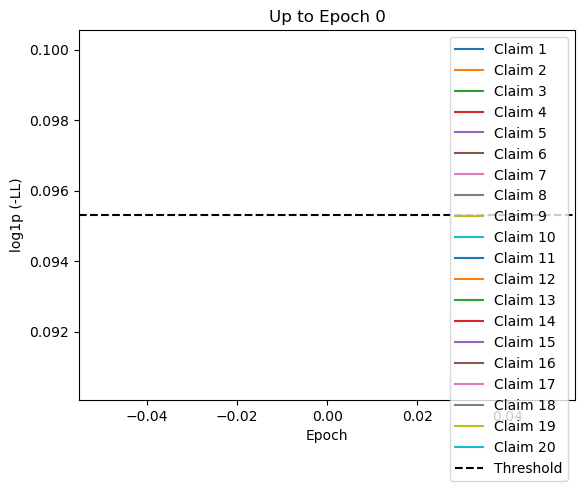

[[         nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan]
 [141.90437317 162.06919861 172.05046082 136.60462952 114.93591309
  113.9907074   90.626091   101.03015137 108.07315063 108.76596069
  128.3167572  114.58921814  93.9072113   76.07652283  80.06466675
  114.06435394 106.33930969  82.0499649   75.81932068 106.22695923]
 [102.30653381 102.14821625 106.59033203 105.55708313  86.55670929
  101.49977112  93.86036682  89.77324677 106.99784851 117.11149597
  127.75505066 105.23817444  90.62355804  70.28164673  72.74121857
  115.91895294 106.73820496  80.50976562  87.31828308 116.93499756]]
[[         nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan     

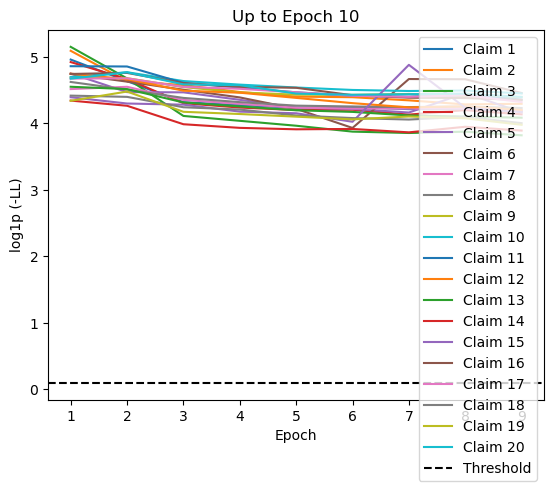

[[         nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan]
 [141.90437317 162.06919861 172.05046082 136.60462952 114.93591309
  113.9907074   90.626091   101.03015137 108.07315063 108.76596069
  128.3167572  114.58921814  93.9072113   76.07652283  80.06466675
  114.06435394 106.33930969  82.0499649   75.81932068 106.22695923]
 [102.30653381 102.14821625 106.59033203 105.55708313  86.55670929
  101.49977112  93.86036682  89.77324677 106.99784851 117.11149597
  127.75505066 105.23817444  90.62355804  70.28164673  72.74121857
  115.91895294 106.73820496  80.50976562  87.31828308 116.93499756]
 [ 74.22309875  96.33851624  60.16040421  73.06019592  86.25675964
   89.76032257  76.86990356  79.22740173  93.46435547 102.42729187
   99.55497742  88.43074036  73.94616699  52.98194122  71.4

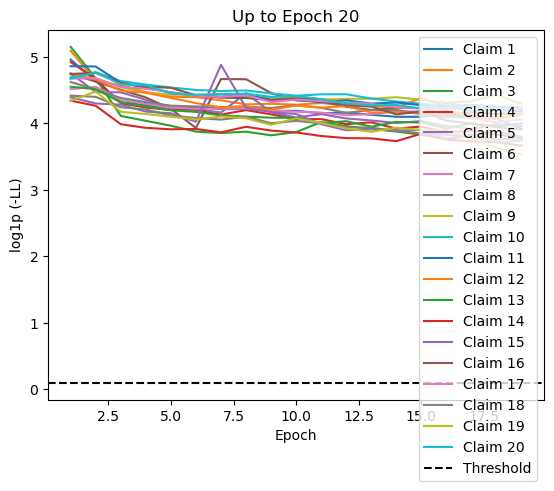

[[         nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan]
 [141.90437317 162.06919861 172.05046082 136.60462952 114.93591309
  113.9907074   90.626091   101.03015137 108.07315063 108.76596069
  128.3167572  114.58921814  93.9072113   76.07652283  80.06466675
  114.06435394 106.33930969  82.0499649   75.81932068 106.22695923]
 [102.30653381 102.14821625 106.59033203 105.55708313  86.55670929
  101.49977112  93.86036682  89.77324677 106.99784851 117.11149597
  127.75505066 105.23817444  90.62355804  70.28164673  72.74121857
  115.91895294 106.73820496  80.50976562  87.31828308 116.93499756]
 [ 74.22309875  96.33851624  60.16040421  73.06019592  86.25675964
   89.76032257  76.86990356  79.22740173  93.46435547 102.42729187
   99.55497742  88.43074036  73.94616699  52.98194122  71.4

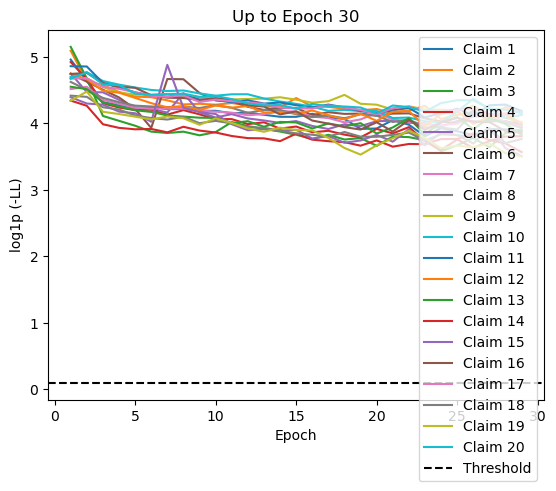

[[         nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan]
 [141.90437317 162.06919861 172.05046082 136.60462952 114.93591309
  113.9907074   90.626091   101.03015137 108.07315063 108.76596069
  128.3167572  114.58921814  93.9072113   76.07652283  80.06466675
  114.06435394 106.33930969  82.0499649   75.81932068 106.22695923]
 [102.30653381 102.14821625 106.59033203 105.55708313  86.55670929
  101.49977112  93.86036682  89.77324677 106.99784851 117.11149597
  127.75505066 105.23817444  90.62355804  70.28164673  72.74121857
  115.91895294 106.73820496  80.50976562  87.31828308 116.93499756]
 [ 74.22309875  96.33851624  60.16040421  73.06019592  86.25675964
   89.76032257  76.86990356  79.22740173  93.46435547 102.42729187
   99.55497742  88.43074036  73.94616699  52.98194122  71.4

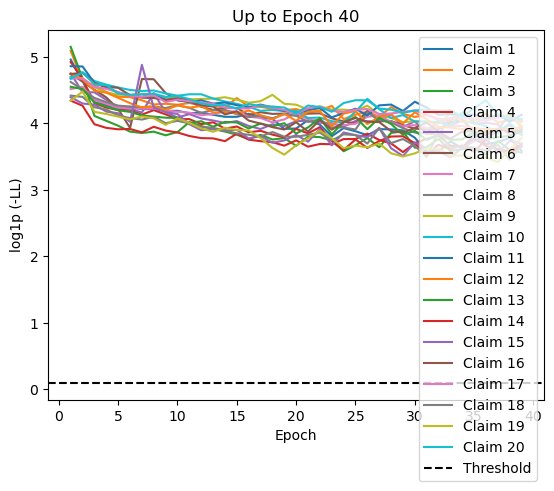

[[         nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan]
 [141.90437317 162.06919861 172.05046082 136.60462952 114.93591309
  113.9907074   90.626091   101.03015137 108.07315063 108.76596069
  128.3167572  114.58921814  93.9072113   76.07652283  80.06466675
  114.06435394 106.33930969  82.0499649   75.81932068 106.22695923]
 [102.30653381 102.14821625 106.59033203 105.55708313  86.55670929
  101.49977112  93.86036682  89.77324677 106.99784851 117.11149597
  127.75505066 105.23817444  90.62355804  70.28164673  72.74121857
  115.91895294 106.73820496  80.50976562  87.31828308 116.93499756]
 [ 74.22309875  96.33851624  60.16040421  73.06019592  86.25675964
   89.76032257  76.86990356  79.22740173  93.46435547 102.42729187
   99.55497742  88.43074036  73.94616699  52.98194122  71.4

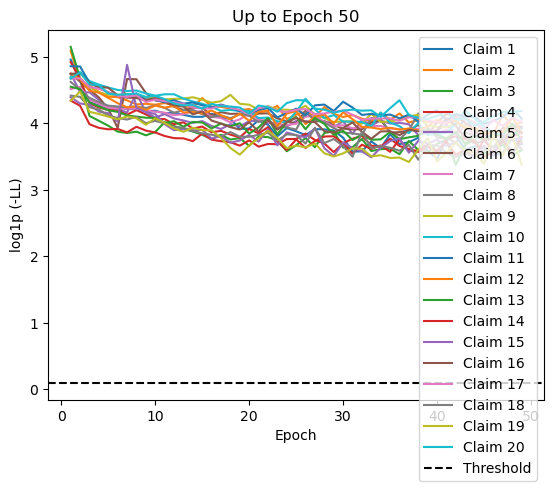

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 44.01335907  54.33501434  32.02070618 ...  36.05407333  34.37256622
   59.33478546]
 [ 36.12776947  60.22893524  40.99249268 ...  39.2224884   33.85891342
   55.33929443]
 [ 33.22774887  52.10261536  30.70872879 ...  37.40843201  29.37618828
   51.75341797]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 36.12776947  60.22893524  40.99249268 ...  39.2224884   33.85891342
   55.33929443]
 [ 33.22774887  52.10261536  30.70872879 ...  37.40843201  29.37618828
   51.75341797]
 [ 31.02387428  49.66986847  32.

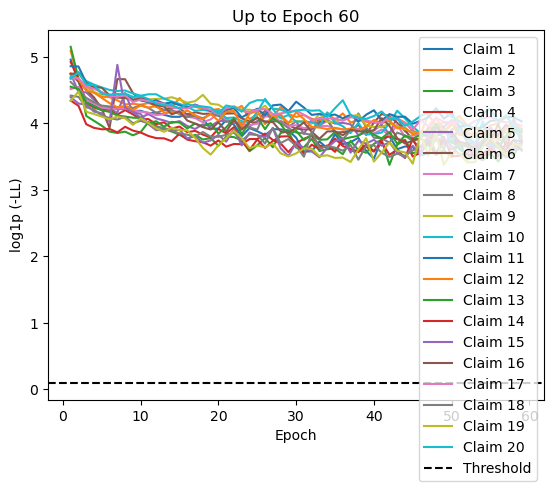

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 27.54920197  50.27503586  34.71520996 ...  39.63246536  37.34565735
   57.92548752]
 [ 35.58207703  50.54833984  36.4180603  ...  34.09213257  38.98735428
   50.58890152]
 [ 43.31335449  51.83052444  31.27596664 ...  34.66449738  30.25617409
   53.70059586]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 35.58207703  50.54833984  36.4180603  ...  34.09213257  38.98735428
   50.58890152]
 [ 43.31335449  51.83052444  31.27596664 ...  34.66449738  30.25617409
   53.70059586]
 [ 33.11563873  51.77152252  33.

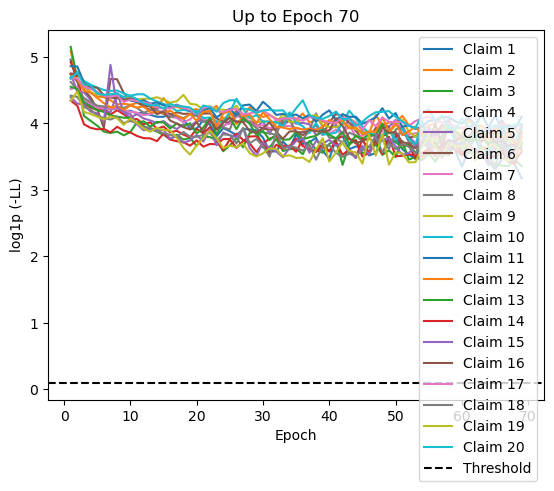

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 37.95075989  48.57721329  41.33527756 ...  25.98433304  42.2064209
   50.03003311]
 [ 40.00535965  48.73717117  31.210289   ...  33.18177032  27.87818146
   54.11169052]
 [ 34.75613022  43.73658371  33.42162323 ...  29.81874084  31.63622856
   51.68608475]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 40.00535965  48.73717117  31.210289   ...  33.18177032  27.87818146
   54.11169052]
 [ 34.75613022  43.73658371  33.42162323 ...  29.81874084  31.63622856
   51.68608475]
 [ 33.38224792  42.27636719  29.7

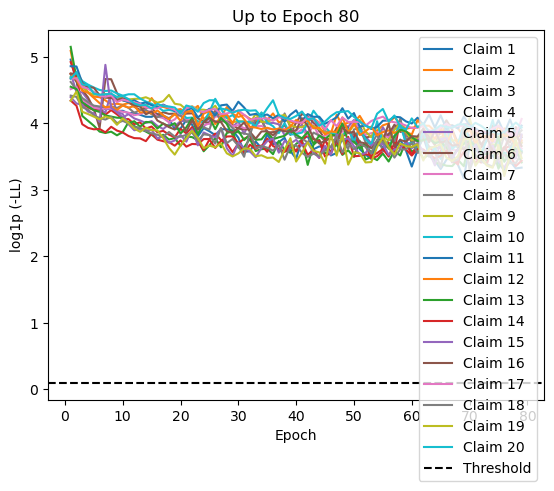

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 28.60676193  47.44168854  32.58638763 ...  36.83747101  29.92610168
   46.4803772 ]
 [ 32.19158936  42.52688599  34.91885376 ...  34.72755814  24.64375114
   60.784729  ]
 [ 26.94345093  47.45184326  28.72986412 ...  27.66041183  33.09420776
   52.50595093]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 32.19158936  42.52688599  34.91885376 ...  34.72755814  24.64375114
   60.784729  ]
 [ 26.94345093  47.45184326  28.72986412 ...  27.66041183  33.09420776
   52.50595093]
 [ 29.62257385  41.86407471  25.

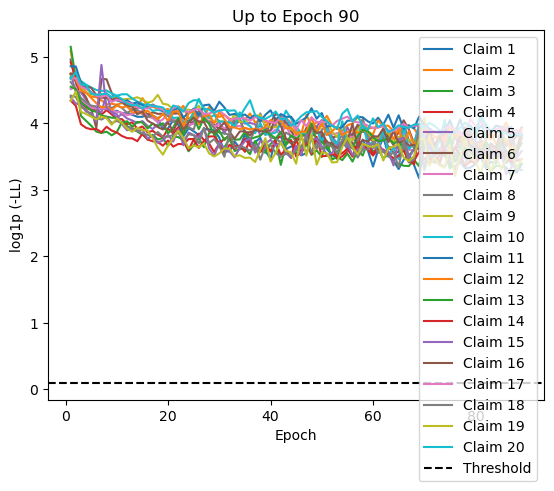

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 40.49245834  43.33869171  29.92733955 ...  28.06292915  27.3703804
   44.79042053]
 [ 36.35186768  37.14735413  32.67975616 ...  30.80920792  27.25224686
   43.7072525 ]
 [ 28.61723328  43.10444641  29.94556046 ...  30.40456581  36.14044952
   47.01752853]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 36.35186768  37.14735413  32.67975616 ...  30.80920792  27.25224686
   43.7072525 ]
 [ 28.61723328  43.10444641  29.94556046 ...  30.40456581  36.14044952
   47.01752853]
 [ 30.19464111  40.89284134  25.4

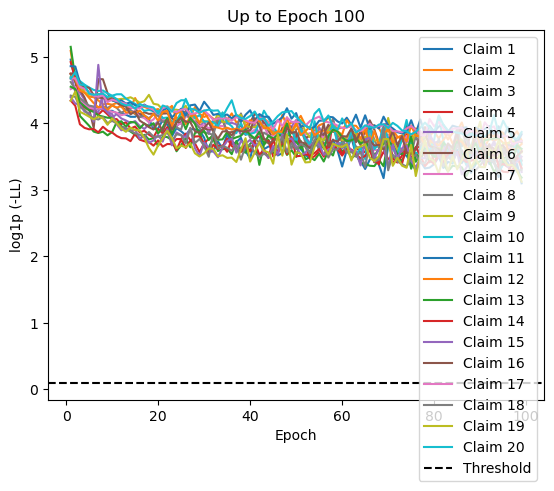

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 23.78842926  42.70475769  26.95982742 ...  31.09757996  25.61920929
   42.45895004]
 [ 28.06320572  39.04798508  24.80794716 ...  32.03059006  31.60354233
   46.92299271]
 [ 28.85211563  40.38033295  28.15955734 ...  25.6899395   32.3367691
   44.00365448]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 28.06320572  39.04798508  24.80794716 ...  32.03059006  31.60354233
   46.92299271]
 [ 28.85211563  40.38033295  28.15955734 ...  25.6899395   32.3367691
   44.00365448]
 [ 27.2121582   38.29219818  26.02

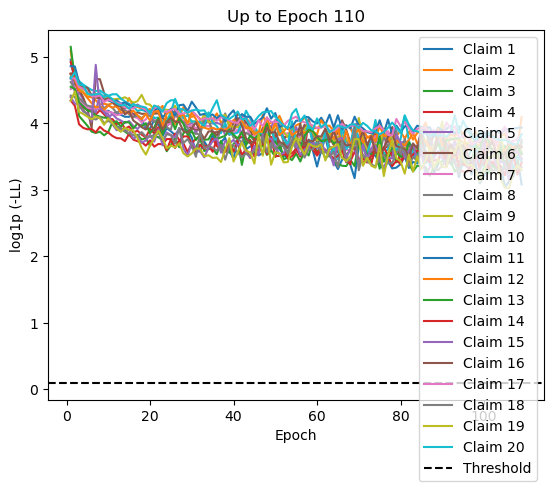

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 26.12234879  48.61873245  34.9019165  ...  30.57040024  23.39544296
   42.33712006]
 [ 23.06686783  42.41279984  24.20579529 ...  39.30532455  26.82088852
   40.56698608]
 [ 26.79492188  37.87051392  21.94993401 ...  30.96658707  25.37797546
   39.71825409]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 23.06686783  42.41279984  24.20579529 ...  39.30532455  26.82088852
   40.56698608]
 [ 26.79492188  37.87051392  21.94993401 ...  30.96658707  25.37797546
   39.71825409]
 [ 21.26475143  36.61503983  19.

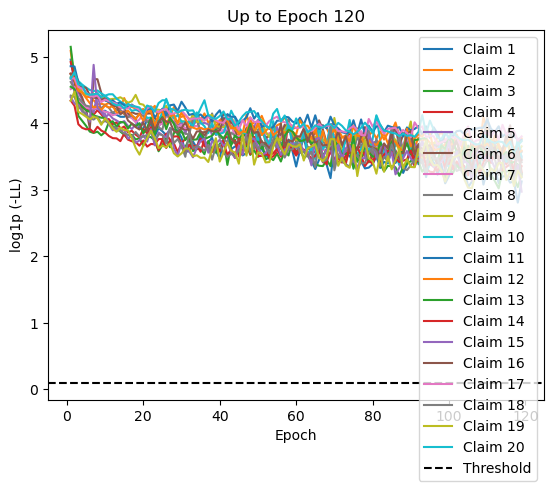

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 28.86619186  42.04301453  27.86232376 ...  30.5679512   27.69162178
   42.7510643 ]
 [ 26.85402298  40.08017349  28.02487564 ...  25.82952499  25.50444031
   42.0462265 ]
 [ 20.29118347  41.66376495  31.74837494 ...  31.49895477  25.22657013
   40.42184448]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 26.85402298  40.08017349  28.02487564 ...  25.82952499  25.50444031
   42.0462265 ]
 [ 20.29118347  41.66376495  31.74837494 ...  31.49895477  25.22657013
   40.42184448]
 [ 20.80095291  36.9694252   26.

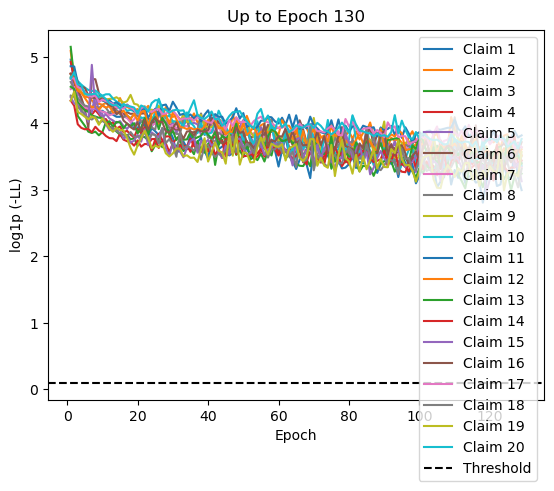

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 29.0496521   33.53216934  29.48356056 ...  27.51132584  26.99723244
   47.0278244 ]
 [ 33.03849792  36.47420502  39.68548584 ...  20.96837425  36.27146149
   43.82679367]
 [ 54.35639191  35.0534668   31.35806274 ...  23.79649734  25.10650635
   34.61270142]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 33.03849792  36.47420502  39.68548584 ...  20.96837425  36.27146149
   43.82679367]
 [ 54.35639191  35.0534668   31.35806274 ...  23.79649734  25.10650635
   34.61270142]
 [ 34.34244919  39.95140457  25.

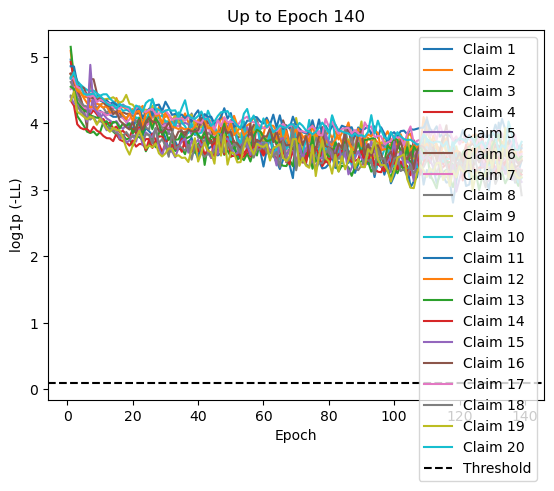

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 21.75257492  33.51726913  19.97380447 ...  30.60720062  32.55394363
   45.3002243 ]
 [ 28.47036743  37.47035217  24.61821747 ...  22.04792213  19.326231
   34.65192413]
 [ 21.55811119  36.38623047  17.1699791  ...  26.71364021  16.95532608
   31.72872353]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 28.47036743  37.47035217  24.61821747 ...  22.04792213  19.326231
   34.65192413]
 [ 21.55811119  36.38623047  17.1699791  ...  26.71364021  16.95532608
   31.72872353]
 [ 20.00306892  36.37258148  21.2048

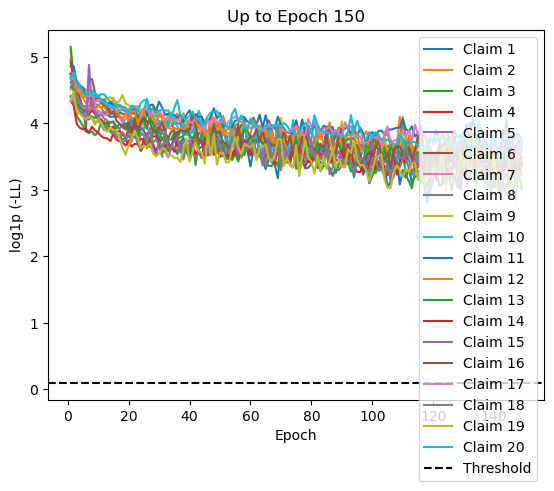

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 34.27286148  31.39058685  22.12361717 ...  28.60484123  32.79756165
   45.01619339]
 [ 34.60155487  40.6765213   28.96227074 ...  26.93880081  19.49662399
   38.1669693 ]
 [ 21.6771965   35.97524643  20.62556076 ...  23.00339699  23.80345917
   35.52261734]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 34.60155487  40.6765213   28.96227074 ...  26.93880081  19.49662399
   38.1669693 ]
 [ 21.6771965   35.97524643  20.62556076 ...  23.00339699  23.80345917
   35.52261734]
 [ 18.01080322  33.63279343  17.

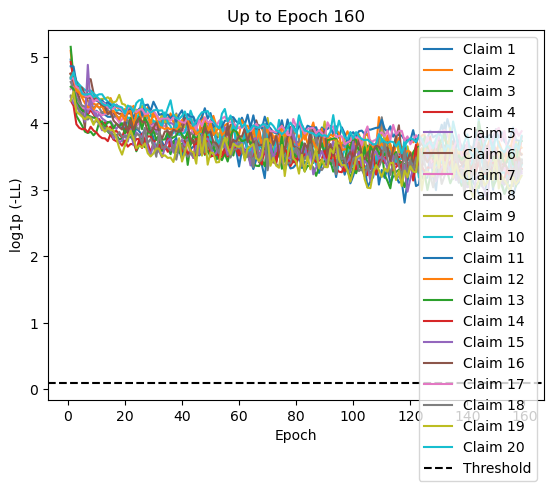

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 17.99882889  38.08721161  21.99762726 ...  25.30676079  22.56817627
   34.92630386]
 [ 19.09608269  39.30311966  27.46377182 ...  30.50011826  19.90747452
   30.67617416]
 [ 19.67284584  37.32766342  26.71235466 ...  20.17864227  24.64764023
   37.14958191]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 19.09608269  39.30311966  27.46377182 ...  30.50011826  19.90747452
   30.67617416]
 [ 19.67284584  37.32766342  26.71235466 ...  20.17864227  24.64764023
   37.14958191]
 [ 25.23994827  38.62815094  23.

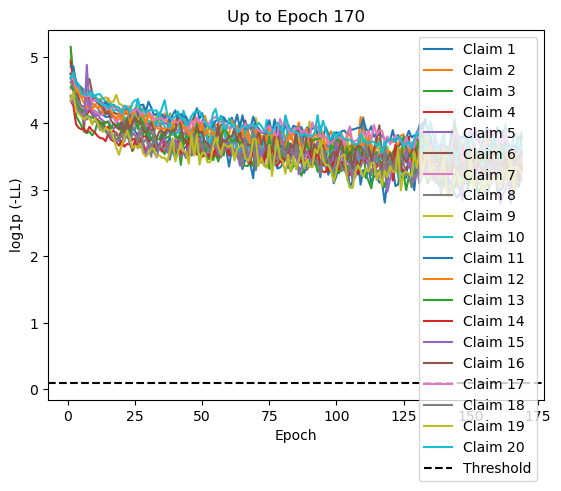

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 26.76834106  33.66430664  28.6389122  ...  27.6832962   31.55864906
   42.95606232]
 [ 22.27131653  38.42848587  38.78914642 ...  33.88668442  27.45198631
   44.35728455]
 [ 16.74372101  39.61797714  27.06287003 ...  21.45315361  23.52902222
   36.08910751]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 22.27131653  38.42848587  38.78914642 ...  33.88668442  27.45198631
   44.35728455]
 [ 16.74372101  39.61797714  27.06287003 ...  21.45315361  23.52902222
   36.08910751]
 [ 19.96644592  40.19837189  26.

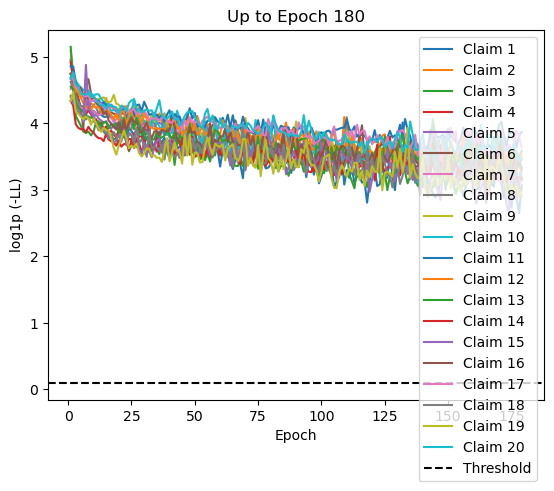

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 30.38144493  32.90419006  19.30498505 ...  27.98464203  25.17257881
   32.63587189]
 [ 31.98919678  34.67919922  25.6223259  ...  32.37492371  31.09356689
   35.65198898]
 [ 42.75672913  33.68144989  51.92987442 ...  25.19164848  24.73023415
   31.08457756]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 31.98919678  34.67919922  25.6223259  ...  32.37492371  31.09356689
   35.65198898]
 [ 42.75672913  33.68144989  51.92987442 ...  25.19164848  24.73023415
   31.08457756]
 [ 27.75189781  33.20609283  23.

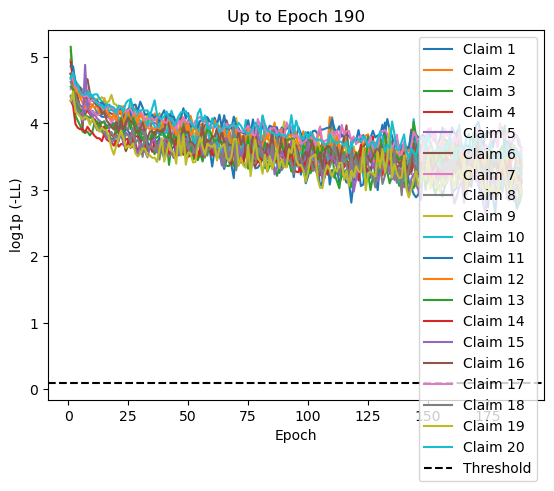

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 25.81775665  29.92710304  18.98515129 ...  28.00039482  15.16594696
   28.04033089]
 [ 20.06941605  28.55531693  15.528759   ...  23.51814461  17.87925339
   33.32801819]
 [ 16.64743805  29.25127983  17.64313698 ...  35.06745911  21.18512535
   31.8373909 ]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 20.06941605  28.55531693  15.528759   ...  23.51814461  17.87925339
   33.32801819]
 [ 16.64743805  29.25127983  17.64313698 ...  35.06745911  21.18512535
   31.8373909 ]
 [ 19.6352005   28.07763672  21.

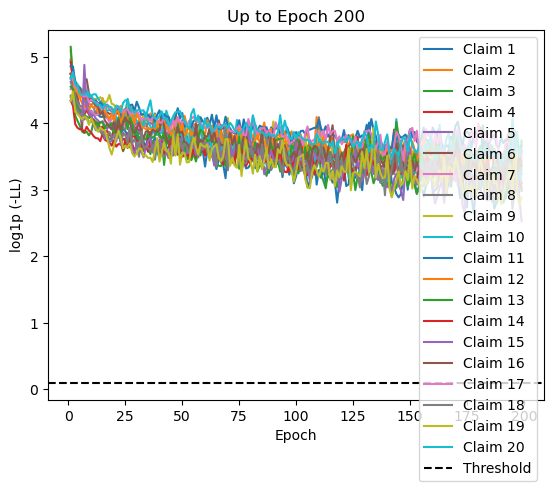

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 14.68372345  32.29824066  28.95528412 ...  19.14677429  20.62311745
   31.86867905]
 [ 18.87512207  31.56999207  28.1718483  ...  23.86299515  16.43139839
   36.20654297]
 [ 16.97867203  31.96818733  19.5731144  ...  31.34841156  20.51290131
   31.89183044]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 18.87512207  31.56999207  28.1718483  ...  23.86299515  16.43139839
   36.20654297]
 [ 16.97867203  31.96818733  19.5731144  ...  31.34841156  20.51290131
   31.89183044]
 [ 21.68798256  33.40428162  16.

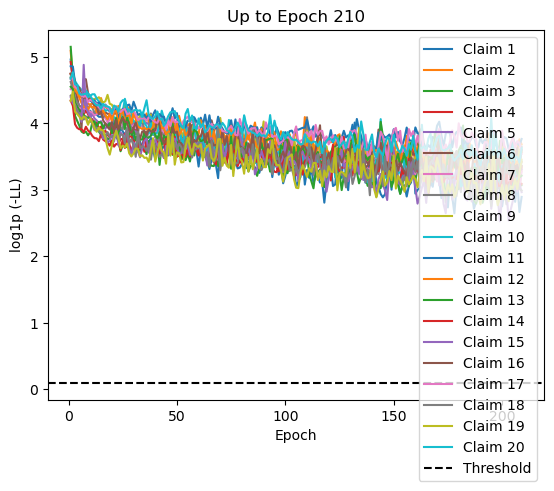

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 14.8265276   31.64125443  32.0202179  ...  28.85713959  17.29010201
   31.5894146 ]
 [ 28.60417175  32.95135498  24.43913269 ...  21.61512375  24.14312363
   27.77005768]
 [ 37.4686203   37.00400543  17.19668579 ...  25.03675461  16.6635704
   36.63136292]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 28.60417175  32.95135498  24.43913269 ...  21.61512375  24.14312363
   27.77005768]
 [ 37.4686203   37.00400543  17.19668579 ...  25.03675461  16.6635704
   36.63136292]
 [ 24.58883286  33.42555237  16.35

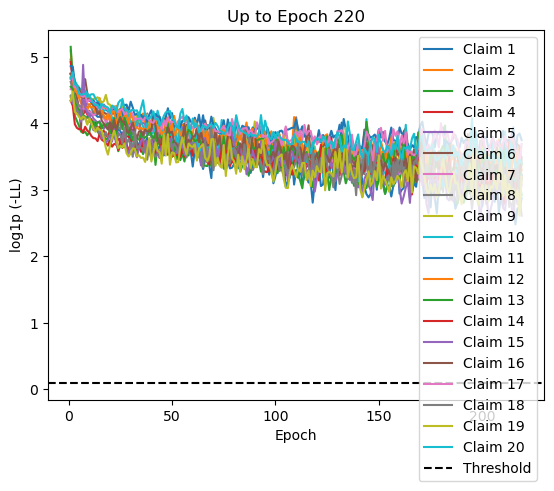

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 14.37821007  25.79679298  23.3785553  ...  23.69042969  20.48732376
   31.08038712]
 [ 16.94288445  33.3890152   15.84870338 ...  15.79652214  18.78612137
   33.46527863]
 [ 13.99065399  31.58977699  18.65377426 ...  20.61056137  22.76365089
   43.77908325]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 16.94288445  33.3890152   15.84870338 ...  15.79652214  18.78612137
   33.46527863]
 [ 13.99065399  31.58977699  18.65377426 ...  20.61056137  22.76365089
   43.77908325]
 [ 12.67628193  31.03204727  16.

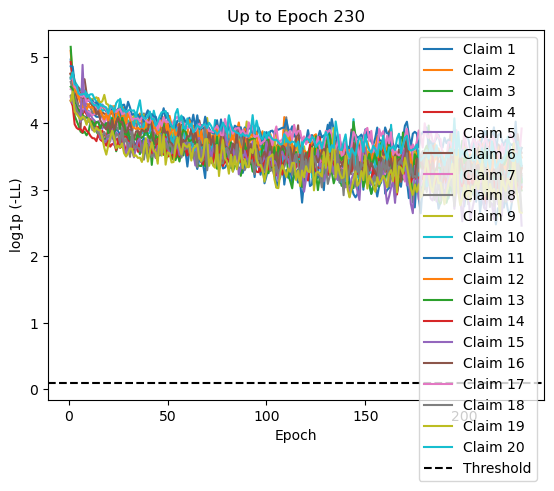

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 15.24295235  31.58062744  21.03481865 ...  16.09722328  10.61425781
   38.11378479]
 [ 14.06591797  33.68766022  24.07738113 ...  13.89290905  13.95897102
   30.67307854]
 [ 13.03664207  29.90485001  17.707901   ...  12.48872662  16.48142815
   36.10555267]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 14.06591797  33.68766022  24.07738113 ...  13.89290905  13.95897102
   30.67307854]
 [ 13.03664207  29.90485001  17.707901   ...  12.48872662  16.48142815
   36.10555267]
 [ 14.98558235  32.19794846  12.

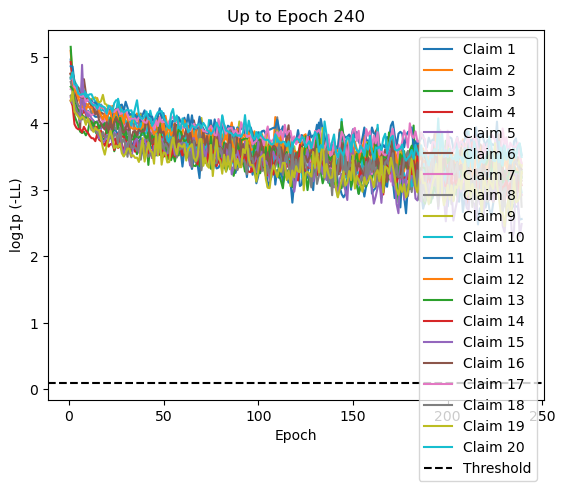

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 12.90615463  33.97204971  16.5691452  ...  12.25872421  16.52618027
   26.01080513]
 [ 12.34130478  36.86120605  30.20362091 ...  28.08827972  21.25054741
   26.66772842]
 [ 12.34781837  34.48806763  22.64235306 ...  29.50450516  10.42034149
   24.45957947]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 12.34130478  36.86120605  30.20362091 ...  28.08827972  21.25054741
   26.66772842]
 [ 12.34781837  34.48806763  22.64235306 ...  29.50450516  10.42034149
   24.45957947]
 [ 12.50681973  35.21381378  17.

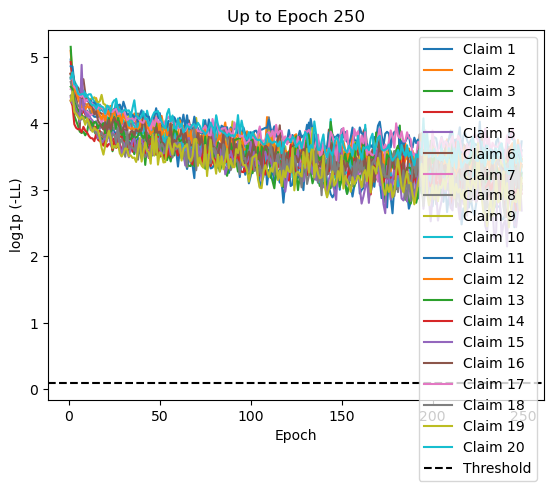

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 29.12761688  35.24815369  20.42456627 ...  23.39855957  17.50315475
   35.19893265]
 [ 15.45360184  36.95359802  24.56884766 ...  13.66492844  18.03044891
   22.03534317]
 [ 17.38157082  30.8892746   14.93571186 ...  31.95670128  12.34268761
   24.29352951]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 15.45360184  36.95359802  24.56884766 ...  13.66492844  18.03044891
   22.03534317]
 [ 17.38157082  30.8892746   14.93571186 ...  31.95670128  12.34268761
   24.29352951]
 [ 11.82466507  31.43174553  31.

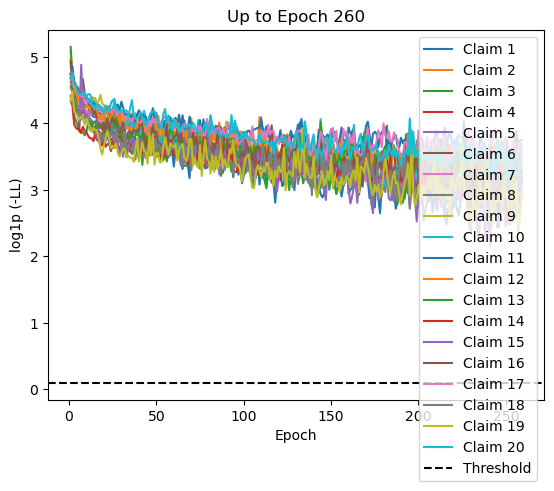

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 19.95887756  33.75988007  23.94244766 ...  13.04220104  18.09696007
   26.98182678]
 [ 15.99078751  34.1528244   24.37974739 ...  17.1801033   17.56813431
   21.94348907]
 [ 18.74193573  38.73886871  30.20344543 ...  10.96130371  12.11629009
   25.55029488]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 15.99078751  34.1528244   24.37974739 ...  17.1801033   17.56813431
   21.94348907]
 [ 18.74193573  38.73886871  30.20344543 ...  10.96130371  12.11629009
   25.55029488]
 [ 15.33512878  42.69689178  19.

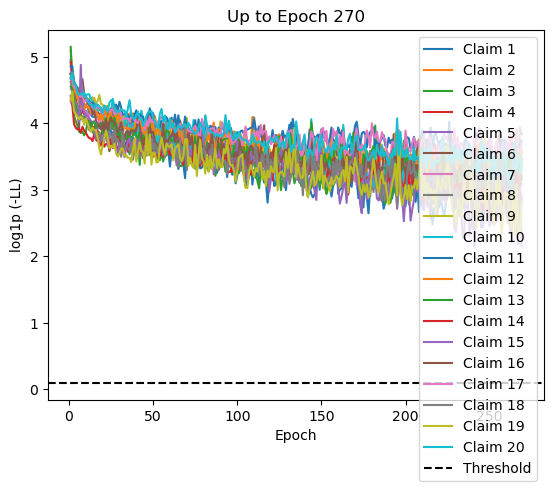

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 11.71403503  37.96060562  19.36265755 ...  23.54428291  10.26490784
   28.47794342]
 [ 15.91300297  32.10652542  17.0280571  ...  11.51753902  11.05846882
   30.15398026]
 [ 13.06537247  31.14518929  21.45137405 ...  15.81652832  10.31038284
   24.67850304]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 15.91300297  32.10652542  17.0280571  ...  11.51753902  11.05846882
   30.15398026]
 [ 13.06537247  31.14518929  21.45137405 ...  15.81652832  10.31038284
   24.67850304]
 [ 14.67707443  31.14387131  15.

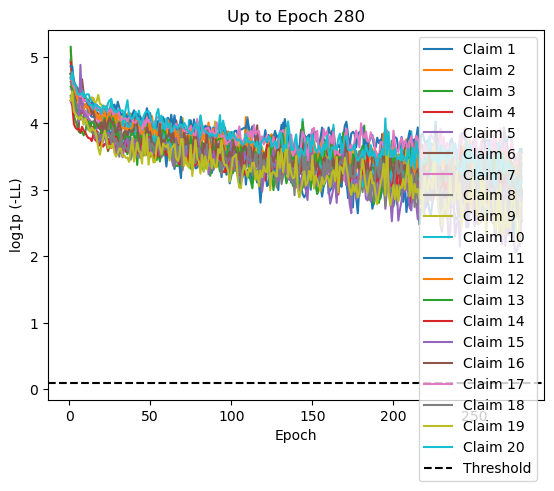

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 13.59559822  32.90062332  19.47291756 ...  28.46518707   8.69236183
   19.60306549]
 [ 12.10427094  26.52302551  17.01317406 ...  27.48549271   7.95171928
   18.68065643]
 [ 13.06627464  30.33580589  15.54829788 ...  30.94639206   9.06420898
   27.61747551]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 12.10427094  26.52302551  17.01317406 ...  27.48549271   7.95171928
   18.68065643]
 [ 13.06627464  30.33580589  15.54829788 ...  30.94639206   9.06420898
   27.61747551]
 [ 30.6570797   30.457201    16.

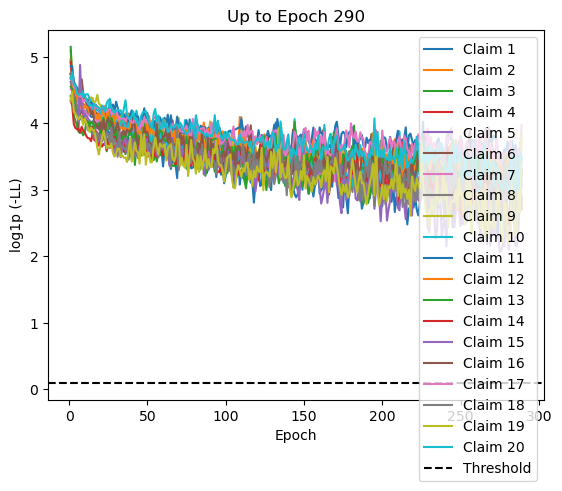

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 21.98688507  29.09695435  15.26462173 ...  19.50336075   9.415061
   31.2435379 ]
 [ 11.95478535  28.24807549  28.16325569 ...  27.1310997   19.85994911
   26.50364685]
 [ 14.83723927  27.85630226  21.92103195 ...  23.0349617    9.42164421
   24.15028572]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 11.95478535  28.24807549  28.16325569 ...  27.1310997   19.85994911
   26.50364685]
 [ 14.83723927  27.85630226  21.92103195 ...  23.0349617    9.42164421
   24.15028572]
 [ 14.63084984  28.95354843  29.34

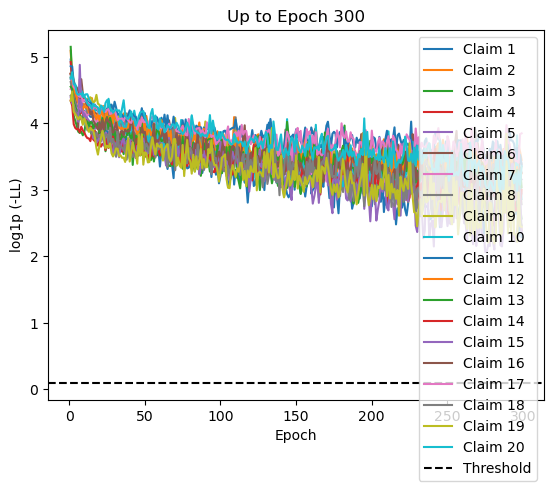

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  9.52000713  29.18182373  13.45413685 ...  23.99324799  18.16188431
   20.74501038]
 [  9.70933247  27.77955627  17.17586136 ...  11.72177696   8.32542419
   17.4131794 ]
 [ 12.83975601  30.37075043  30.71459389 ...  24.89322662   8.18418503
   23.02755737]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  9.70933247  27.77955627  17.17586136 ...  11.72177696   8.32542419
   17.4131794 ]
 [ 12.83975601  30.37075043  30.71459389 ...  24.89322662   8.18418503
   23.02755737]
 [ 23.96487808  30.13528061  19.

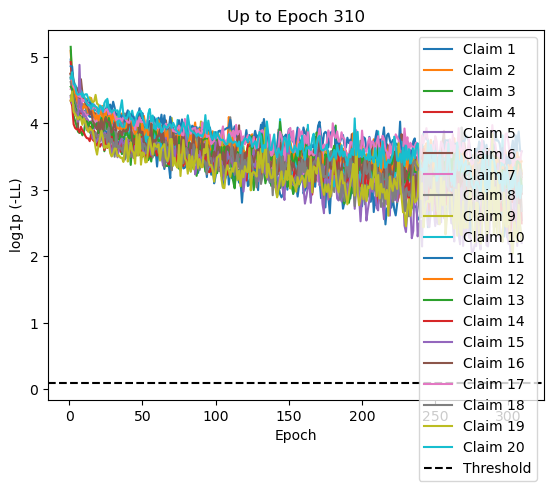

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 14.47112656  30.37917709  20.48136902 ...  26.71456528  12.84358788
   26.26579475]
 [  9.51232147  29.46813202  15.7918539  ...  12.59620094   7.50357437
   19.82404709]
 [ 16.80928421  31.9897995   15.3577404  ...  11.32196808   8.25011826
   17.91308022]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  9.51232147  29.46813202  15.7918539  ...  12.59620094   7.50357437
   19.82404709]
 [ 16.80928421  31.9897995   15.3577404  ...  11.32196808   8.25011826
   17.91308022]
 [ 11.37882805  28.03791237  15.

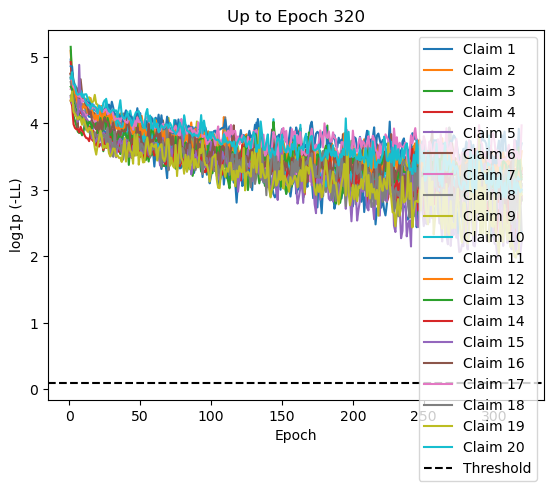

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  6.61407518  37.90901947  25.2187233  ...  10.96088123   9.01220894
   20.08032227]
 [ 10.49040985  43.33315277  28.55997086 ...   8.96507645   7.29347324
   17.00425339]
 [  6.1703968   30.66364288  22.47836304 ...  12.77619553   6.36860085
   16.83903313]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 10.49040985  43.33315277  28.55997086 ...   8.96507645   7.29347324
   17.00425339]
 [  6.1703968   30.66364288  22.47836304 ...  12.77619553   6.36860085
   16.83903313]
 [  7.5160656   29.8241806   16.

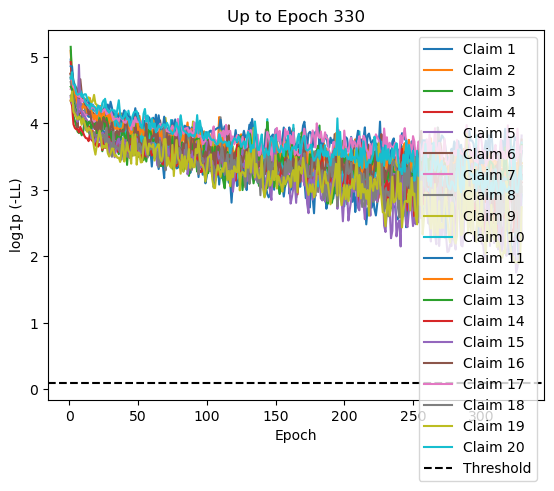

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 12.382761    23.94463158  16.67538643 ...  16.58969307  18.20498276
   23.42795563]
 [ 15.99709797  26.34184837  17.53562355 ...  10.09003258  27.19734192
   20.31620407]
 [ 11.42526817  28.39042854  26.56794357 ...  29.2884922   26.49883652
   25.13865662]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 15.99709797  26.34184837  17.53562355 ...  10.09003258  27.19734192
   20.31620407]
 [ 11.42526817  28.39042854  26.56794357 ...  29.2884922   26.49883652
   25.13865662]
 [ 14.79935646  29.25888062  14.

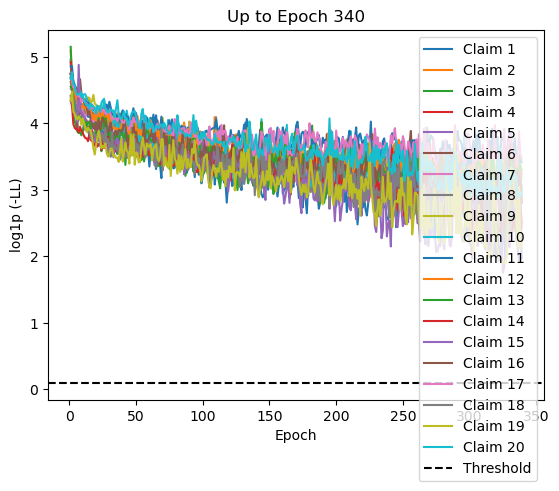

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  7.71632242  27.54703903  12.98476219 ...  30.36196709   6.65627098
   17.92191696]
 [  9.48545456  27.94024277  16.30513763 ...  33.502388     7.23735142
   19.58267593]
 [ 15.85215378  38.5088768   18.55182648 ...  10.96107197  33.18258667
   17.03411102]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  9.48545456  27.94024277  16.30513763 ...  33.502388     7.23735142
   19.58267593]
 [ 15.85215378  38.5088768   18.55182648 ...  10.96107197  33.18258667
   17.03411102]
 [ 10.239645    35.64866257  17.

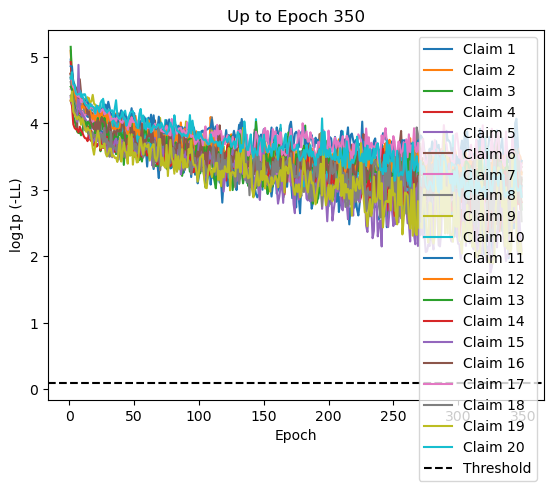

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 16.28708839  25.71729279  16.86561775 ...   9.56403637   6.46257591
   16.98253822]
 [ 17.84202957  26.49078751  16.0325222  ...   9.13659954   5.6173296
   21.15892601]
 [  8.7663517   28.9556427   14.99163437 ...  29.73666763   5.95748711
   18.33320808]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 17.84202957  26.49078751  16.0325222  ...   9.13659954   5.6173296
   21.15892601]
 [  8.7663517   28.9556427   14.99163437 ...  29.73666763   5.95748711
   18.33320808]
 [  7.63477612  27.43153     15.33

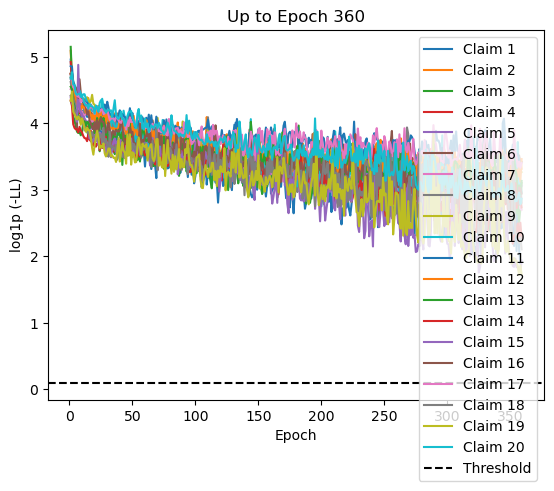

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  4.82024479  28.09453201  18.26942062 ...   7.8434782    5.74678707
   18.40452576]
 [  4.97664118  24.34238815  14.60751629 ...   8.57390785   5.05220842
   15.26781654]
 [  6.29385376  23.47234344   9.6117239  ...   7.70192528   5.204391
   13.24139786]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  4.97664118  24.34238815  14.60751629 ...   8.57390785   5.05220842
   15.26781654]
 [  6.29385376  23.47234344   9.6117239  ...   7.70192528   5.204391
   13.24139786]
 [  9.19764519  25.81663895  12.3382

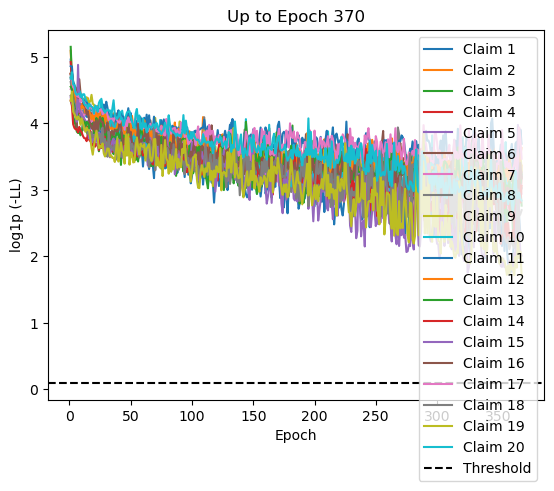

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  7.89763832  19.26514435  12.74754143 ...   7.63764763   5.09170914
   15.91970825]
 [  8.05392456  20.34519768   8.80282593 ...   7.11856365   4.57697296
   13.91769886]
 [  7.32892036  26.49651337   8.75551224 ...   6.33060312   4.54216337
   18.68275833]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  8.05392456  20.34519768   8.80282593 ...   7.11856365   4.57697296
   13.91769886]
 [  7.32892036  26.49651337   8.75551224 ...   6.33060312   4.54216337
   18.68275833]
 [  5.97992325  21.26054573  11.

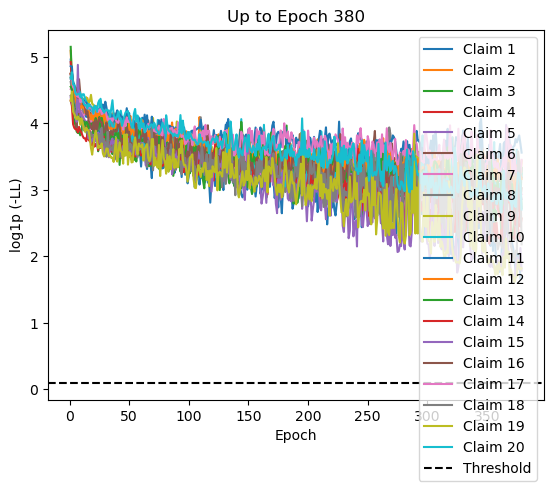

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  4.69942379  26.28577042  19.10928726 ...   7.64425278   4.67984962
   16.87537766]
 [  4.5961647   30.13282776  16.60787964 ...   9.16960335   3.8776226
   23.20462036]
 [  4.02702904  32.9799881   16.78371239 ...  16.45013428  26.84408188
   16.59662247]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  4.5961647   30.13282776  16.60787964 ...   9.16960335   3.8776226
   23.20462036]
 [  4.02702904  32.9799881   16.78371239 ...  16.45013428  26.84408188
   16.59662247]
 [  4.74697495  26.84238815  21.38

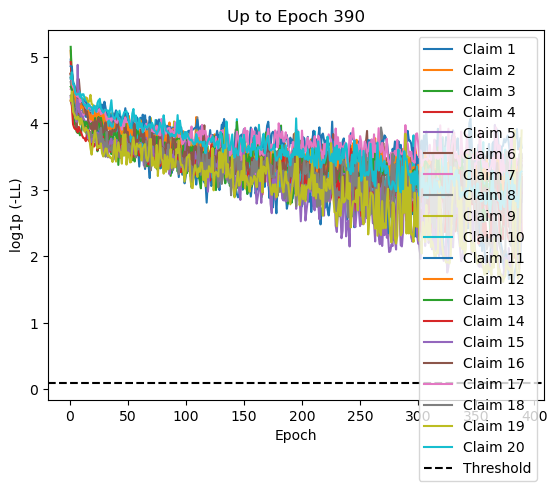

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 25.02968216  31.52668381  17.68144989 ...  19.37845421  45.74741745
   21.11726761]
 [  4.69129753  27.79902649  11.48101807 ...  13.28806973  19.33909988
   18.54441452]
 [  5.49889946  22.05066299  10.40030766 ...   8.25515079   8.01862335
   15.22622108]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  4.69129753  27.79902649  11.48101807 ...  13.28806973  19.33909988
   18.54441452]
 [  5.49889946  22.05066299  10.40030766 ...   8.25515079   8.01862335
   15.22622108]
 [  5.00310516  25.12766838  18.

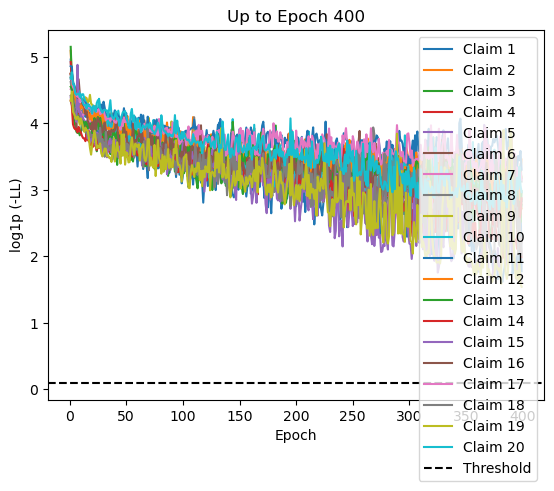

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  3.74245119  23.29618645  10.74992466 ...  14.76469612   3.77868915
   15.01180267]
 [  4.40795517  28.24291039  14.37097263 ...   9.48248672   3.79021239
   19.86256981]
 [ 20.10909653  29.63074112   9.11349487 ...  23.07474899   5.3898735
   21.61108971]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  4.40795517  28.24291039  14.37097263 ...   9.48248672   3.79021239
   19.86256981]
 [ 20.10909653  29.63074112   9.11349487 ...  23.07474899   5.3898735
   21.61108971]
 [ 10.71731949  18.49224281  19.49

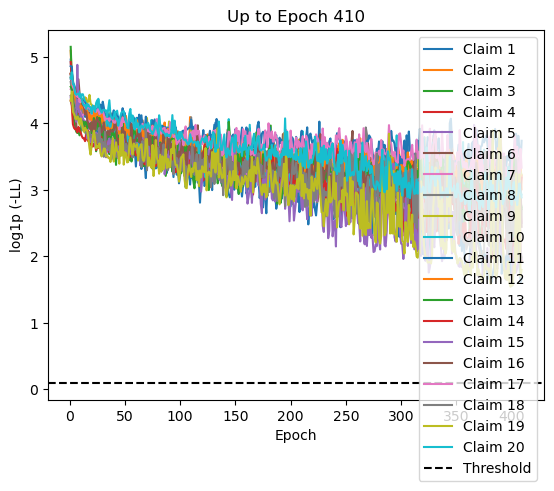

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  3.56291628  18.41973686   9.69130325 ...   6.45144463   4.95996523
   16.16019821]
 [  3.76561737  27.85822868   8.12147903 ...   5.8143177    5.19306564
   15.95777893]
 [  4.1455164   19.59619904   9.02413177 ...   6.28034687   4.07760811
   18.49461746]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  3.76561737  27.85822868   8.12147903 ...   5.8143177    5.19306564
   15.95777893]
 [  4.1455164   19.59619904   9.02413177 ...   6.28034687   4.07760811
   18.49461746]
 [  3.59467149  22.07312775  14.

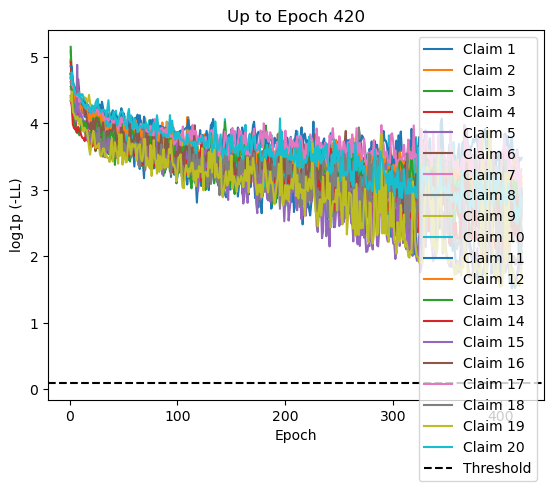

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  9.17587185  18.26643562   9.55163193 ...   6.17126703   4.8543849
   43.77737808]
 [ 19.95205688  29.08052254   7.65496254 ...   8.16187191   6.16744995
   19.99159622]
 [ 21.03390884  23.67130661   7.96505165 ...  16.75823021   3.6852479
   18.66890144]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 19.95205688  29.08052254   7.65496254 ...   8.16187191   6.16744995
   19.99159622]
 [ 21.03390884  23.67130661   7.96505165 ...  16.75823021   3.6852479
   18.66890144]
 [  8.42747593  26.63927841  17.253

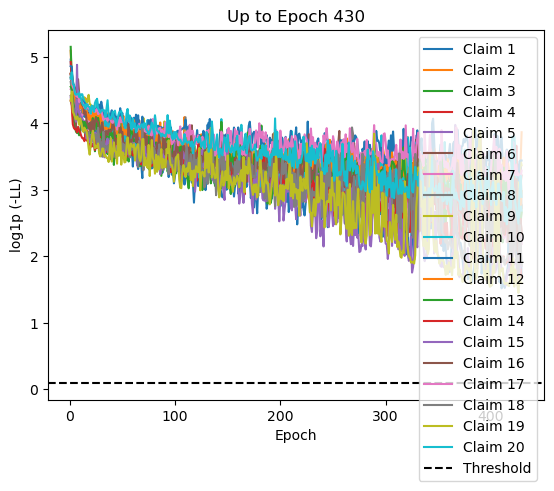

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  4.10650873  30.40906143   9.63770103 ...   5.18919277   3.70897722
   15.69591999]
 [  3.88736391  23.14061737   9.5537262  ...   4.60216236   3.7360692
   15.37745762]
 [  3.76168752  26.50723648  20.05222321 ...   4.85575533   3.37008262
   12.66893387]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  3.88736391  23.14061737   9.5537262  ...   4.60216236   3.7360692
   15.37745762]
 [  3.76168752  26.50723648  20.05222321 ...   4.85575533   3.37008262
   12.66893387]
 [  8.30728149  28.48362732   7.95

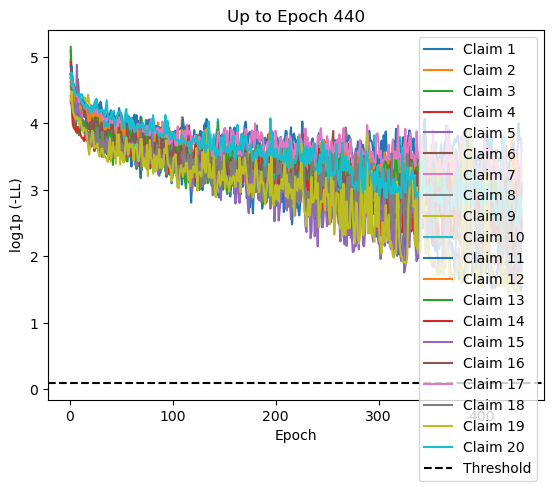

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  3.25564432  20.19800186  16.5318985  ...   5.26745081   4.49958229
   13.51891518]
 [  3.50260735  17.19822502  19.16049957 ...   4.84533167   3.15023088
   12.44112778]
 [ 18.42598534  22.51606941   8.2217741  ...  14.51100349   3.53206968
    8.88917542]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  3.50260735  17.19822502  19.16049957 ...   4.84533167   3.15023088
   12.44112778]
 [ 18.42598534  22.51606941   8.2217741  ...  14.51100349   3.53206968
    8.88917542]
 [ 10.75013447  19.83770752  12.

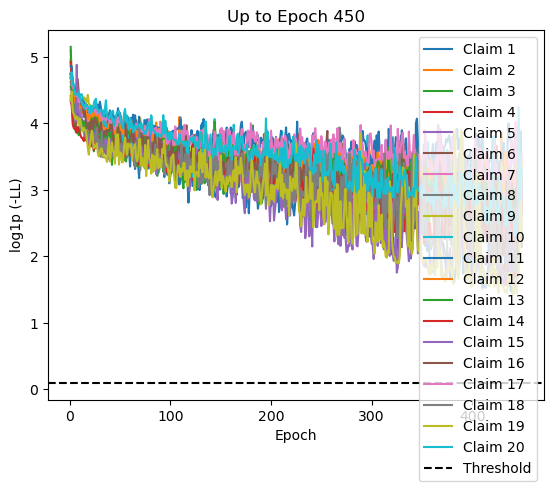

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  9.4688549   19.28968811  11.20667744 ...   5.44052887   3.49102855
   12.83255863]
 [  5.75753403  21.94221878  18.53211594 ...   8.34313011   3.52913713
   13.55833435]
 [ 20.6674118   17.65727425   9.83840942 ...   4.96879339   3.54722738
   12.06999493]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  5.75753403  21.94221878  18.53211594 ...   8.34313011   3.52913713
   13.55833435]
 [ 20.6674118   17.65727425   9.83840942 ...   4.96879339   3.54722738
   12.06999493]
 [  5.47292614  22.34420204  20.

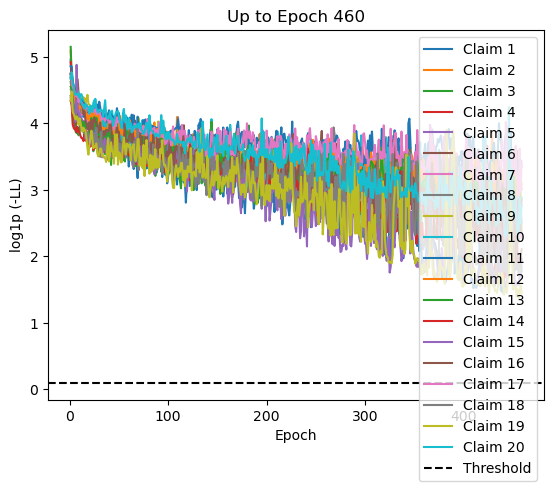

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  4.36664104  17.96936989  24.43399048 ...   4.77705002   3.22823238
    8.67672157]
 [  4.06865406  29.90782166   9.8269577  ...   4.54435635   3.28066087
    8.96144295]
 [  4.8582654   27.35726166   7.95304918 ...  15.57514191   2.85257554
   11.34022236]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  4.06865406  29.90782166   9.8269577  ...   4.54435635   3.28066087
    8.96144295]
 [  4.8582654   27.35726166   7.95304918 ...  15.57514191   2.85257554
   11.34022236]
 [  5.21356964  18.64450836   8.

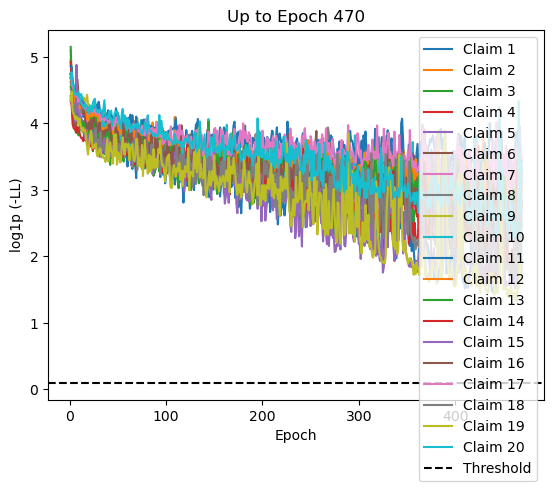

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  3.96584034  18.69734764  25.42704964 ...   5.32649136   3.58933878
   12.33872604]
 [  3.66520643  16.9517765   16.82771301 ...   5.6988678    2.72762966
   13.75099754]
 [  3.32614946  16.57959938   8.95580864 ...   4.23078156   3.56528568
    8.73414135]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  3.66520643  16.9517765   16.82771301 ...   5.6988678    2.72762966
   13.75099754]
 [  3.32614946  16.57959938   8.95580864 ...   4.23078156   3.56528568
    8.73414135]
 [  3.49891162  17.21887016   8.

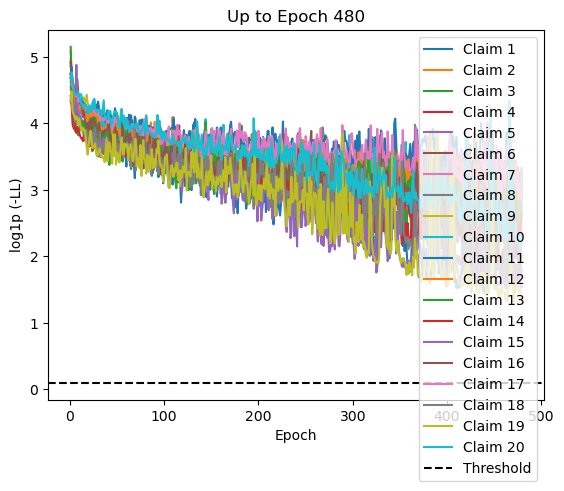

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [ 12.91974163  16.05912018   7.04881763 ...   5.70077991   3.43306351
    8.06541252]
 [  6.03945351  15.54805183  14.61436462 ...   6.91666603   2.92314553
    9.12479782]
 [ 33.53027344  14.89099312  29.16386032 ...   6.79594564   4.55975389
   12.88745499]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  6.03945351  15.54805183  14.61436462 ...   6.91666603   2.92314553
    9.12479782]
 [ 33.53027344  14.89099312  29.16386032 ...   6.79594564   4.55975389
   12.88745499]
 [ 17.38925743  27.71651077  16.

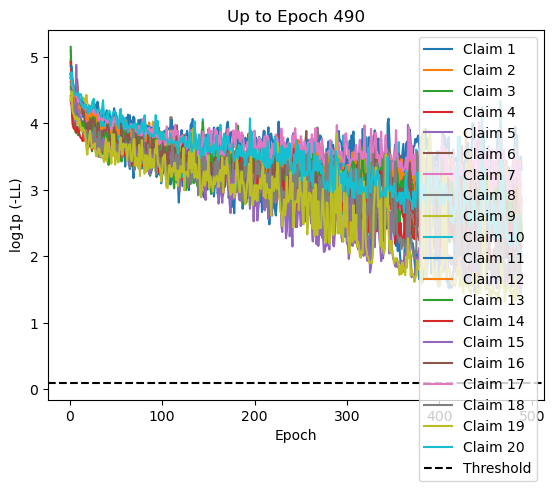

[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  3.0339148   29.15450096  10.14172363 ...   5.12624025   2.59063888
    7.61024761]
 [  3.14595175  20.29459381  30.88644791 ...   4.78703022   2.93508625
    6.47455788]
 [  4.17566013  37.47221756  32.60803223 ...   5.56896114   2.84380221
    7.89857149]]
[[         nan          nan          nan ...          nan          nan
           nan]
 [141.90437317 162.06919861 172.05046082 ...  82.0499649   75.81932068
  106.22695923]
 [102.30653381 102.14821625 106.59033203 ...  80.50976562  87.31828308
  116.93499756]
 ...
 [  3.14595175  20.29459381  30.88644791 ...   4.78703022   2.93508625
    6.47455788]
 [  4.17566013  37.47221756  32.60803223 ...   5.56896114   2.84380221
    7.89857149]
 [  4.1514349   25.02490044   9.

KeyboardInterrupt: 

In [32]:
# works! 410s at lr=1 (4 claims);
# Training the autoencoder
# Loss function and optimizer
optimizer = optim.Adam(ae.parameters(), lr=1)
epoch = 0
dEps = 0.1
bStop = False
aLLHistory = np.ones((1, tOHETarget.shape[0]))
aLLHistory[0, :] = np.nan
aLLHistory = np.ones((1, tOHETarget.shape[0]))
aLLHistory[0, :] = np.nan

while not bStop:
    tic = time.time()
    aStore = np.zeros((1, tOHETarget.shape[0]))
    dLLJoint = torch.tensor(0.0, requires_grad=True)
    lLoss = []
    for i in range(tOHETarget.shape[0]):
        # Forward pass
        ae_outputs = ae(tOHETarget[i, :])
        outputs = lGenerate[i](ae_outputs.reshape(1, 1, -1))
        loss = llikelihood(outputs, lTargetSequence[i])
        aStore[0, i] = loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #lLoss.append(loss)
    # Compute the joint loss
    #joint_loss = torch.sum(torch.stack(lLoss))
    #joint_loss = dLLJoint.clone()

    # Backward pass and optimization
    #optimizer.zero_grad()
    #joint_loss.backward()
    #optimizer.step()

    aLLHistory = np.vstack([aLLHistory, aStore])
    print(aLLHistory)
    bStop = np.all(aLLHistory[epoch, :] < dEps)

    # Reporting
    if (epoch % 10 == 0) or bStop:
        toc = time.time()
        print(f"EPOCH {epoch}: {aLLHistory[epoch, :]}, joint: {np.sum(aLLHistory[epoch, :])}, time: {10 * np.round(toc - tic, 2)} s")
        for i in range(aLLHistory.shape[1]):
            plt.plot(np.log1p(aLLHistory[0:epoch, i]), label = f"Claim {i + 1}")
        plt.axhline(y=np.log1p(dEps), linestyle='--', color='black', label="Threshold")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("log1p (-LL)")
        plt.title(f"Up to Epoch {epoch}")
        plt.show()

    epoch = 1 + epoch

# Encoding the data using the trained autoencoder
model_scripted = torch.jit.script(ae) # Export to TorchScript
model_scripted.save('autoencoder.pt') # Save
#files.download('autoencoder.pt')

In [12]:
for i in range(tOHETarget.shape[0]):
    print(f"Target: {lTargetStrings[i]}")
    print(f"Generated: {tokenizer.decode(lGenerate[i](ae(tOHETarget[i, :]).reshape(1, 1, -1)).sequences[0])}")

Target: Experience 50% more visible shine after just one use.
Generated: <|endoftext|>Experience 50% more visible shine after just one use.
Target: Formulated with light-reflecting technology for a glossy finish.
Generated: <|endoftext|>Formulated with light-reflecting technology for a glossy finish.
Target: Transform dull strands into radiant, luminous locks.
Generated: <|endoftext|>Transform dull strands into radiant, luminous locks.
Target: Infused with nourishing oils that enhance natural shine.
Generated: <|endoftext|>Infused with nourishing oils that enhance natural shine.
Target: See instant brilliance with our advanced shine-boosting formula.
Generated: <|endoftext|>See instant brilliance with our advanced shine-boosting formula.
Target: Elevate your confidence with hair that gleams under any light.
Generated: <|endoftext|>Elevate your confidence with hair that gleams under any light.
Target: Embrace the allure of luminous hair that turns heads.
Generated: <|endoftext|>Embrace 

In [16]:
encoded_data = ae.encoder(tOHETarget).cpu().detach().numpy()

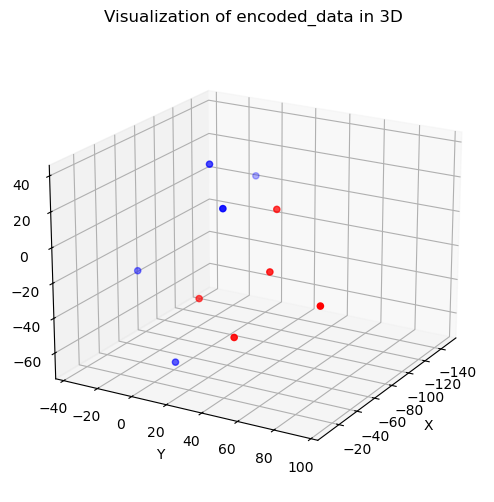

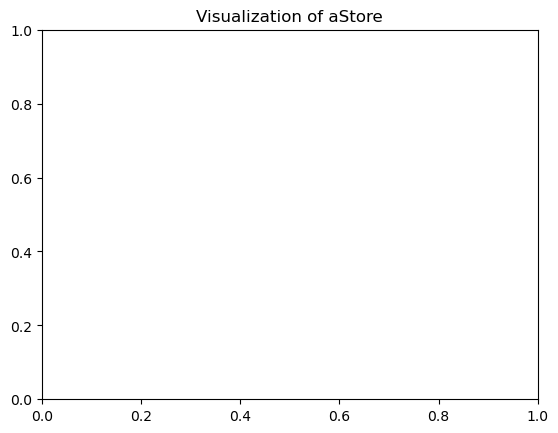

In [29]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Create a list of colors for each row
colors = ['blue'] * 5 + ['red'] * 5

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(encoded_data[:, 0], encoded_data[:, 1], encoded_data[:, 2], c=colors)

# Rotate the angle by 30 degrees
ax.view_init(elev=20, azim=30)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('Visualization of encoded_data in 3D')
plt.show()

# Set the title
plt.title('Visualization of aStore')

# Show the plot
plt.show()


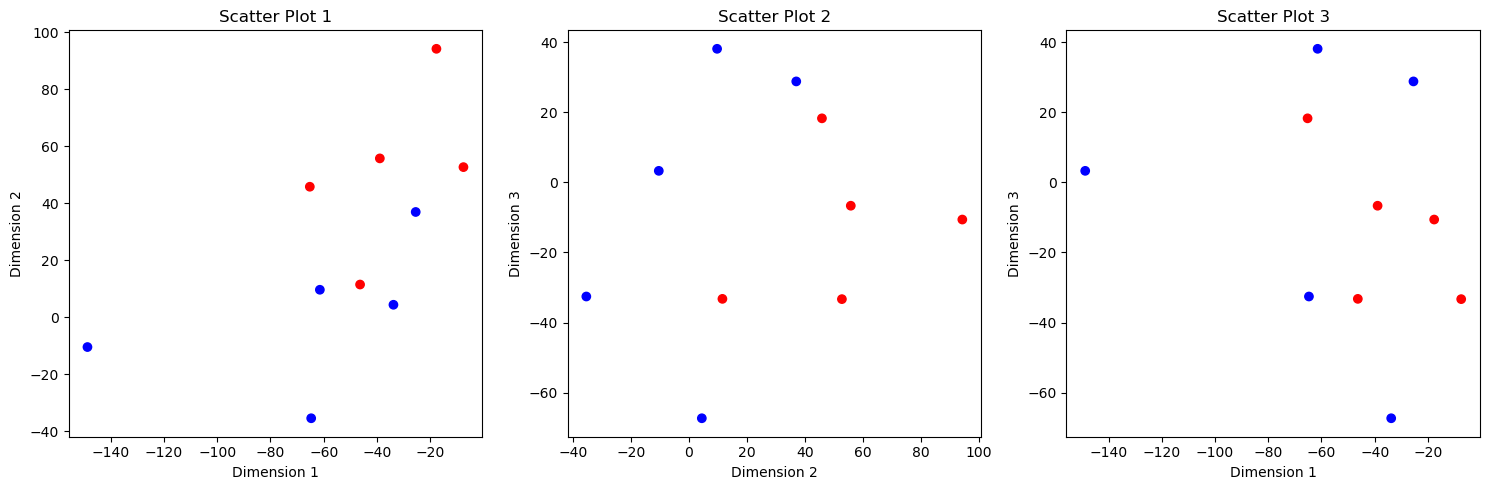

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(encoded_data[:, 0], encoded_data[:, 1], c=colors)
axes[0].set_xlabel('Dimension 1')
axes[0].set_ylabel('Dimension 2')
axes[0].set_title('Scatter Plot 1')

axes[1].scatter(encoded_data[:, 1], encoded_data[:, 2], c=colors)
axes[1].set_xlabel('Dimension 2')
axes[1].set_ylabel('Dimension 3')
axes[1].set_title('Scatter Plot 2')

axes[2].scatter(encoded_data[:, 0], encoded_data[:, 2], c=colors)
axes[2].set_xlabel('Dimension 1')
axes[2].set_ylabel('Dimension 3')
axes[2].set_title('Scatter Plot 3')

plt.tight_layout()
plt.show()
